# PART A: TIME SERIES (50 marks)
Background


a. Using the Energy Consumption Dataset to train time series models and forecast
the gas consumption, electricity consumption and water consumption in the
future.


b. You will be given a csv dataset to build your time series model.
Tasks


1. Write the code to solve the time series prediction. For the time series model,
use Statsmodels only (do not use other 3rd party libraries such as autoML).


2. Tune the hyperparameters of the time series model to maximize the accuracy
for training data and testing data prediction.


3. Write a short report detailing your implementation, your experiments and
analysis in the Jupyter notebook (along with your python code and comments).


4. Create a set of slides with the highlights of your Jupyter notebook. Explain the
time series prediction process, model building and evaluation. Write your
conclusions.






Evaluation criteria:


Background Research & Data Exploration 25%


Modelling and Evaluation 25%


Model Improvement 25%


Demo/Presentation and Quality of report (Jupyter) 25%


# Data Exploration

## Data Dictionary
| Columns | Descriptions |
| :--     | :--          |
| DATE | Date of the entry in **DD/MM/YYYY** format (DATETIME) |
| Gas Consumption (tons) | Gas Consumption in **tons** from previous time to current time stamp (float) |
| Electricity Consumption (MWh) | Electricity Consumption in **MWh** from previous time to current time stamp (float) |
| Water Consumption (tons) | Water Consumption in **tons** from previous time to current time stamp (float) |

## Data analysis

Perform EDA on the dataset and process it in a way that is more suitable for the assignment based on the insights gained

In [8]:
#import the libraries needed for Data Exploration


import pandas as pd
import seaborn as sns
import numpy as np
from numpy import poly1d
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
import warnings 
warnings.filterwarnings('ignore')


#import the libraries needed for modelling
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
#set the style for the plots
sns.set_style('darkgrid')

#set the size of the plots
plt.rcParams['figure.figsize'] = (15, 8)


In [10]:
#import the data 

initialdata = pd.read_csv('data/Energy Consumption Dataset.csv', parse_dates=['DATE'], index_col='DATE')

#view the dataframe info
initialdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1990-01-01 to 2023-01-01
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Gas Consumption (tons)         397 non-null    float64
 1   Electricity Consumption (MWh)  397 non-null    float64
 2   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3)
memory usage: 12.4 KB


In [11]:
#view the details/summary of the dataframe's statistics
initialdata.describe()

Gas Consumption (tons)  Electricity Consumption (MWh)  \
count              397.000000                     397.000000   
mean                23.785139                     888.472544   
std                  4.903452                     153.877594   
min                 11.600000                     553.200000   
25%                 20.200000                     771.100000   
50%                 23.500000                     897.800000   
75%                 27.900000                    1005.200000   
max                 46.000000                    1294.000000   

       Water Consumption (tons)  
count                397.000000  
mean                 484.953652  
std                  133.908863  
min                   44.400000  
25%                  384.400000  
50%                  487.400000  
75%                  580.200000  
max                  811.000000

In [12]:
initialdata.index = initialdata.index.strftime("%Y-%d-%m")
initialdata.index = pd.DatetimeIndex(initialdata.index, freq='MS')


### Trend/Pattern over time

We can plot the data overtime to identify the trends and patterns in the data.

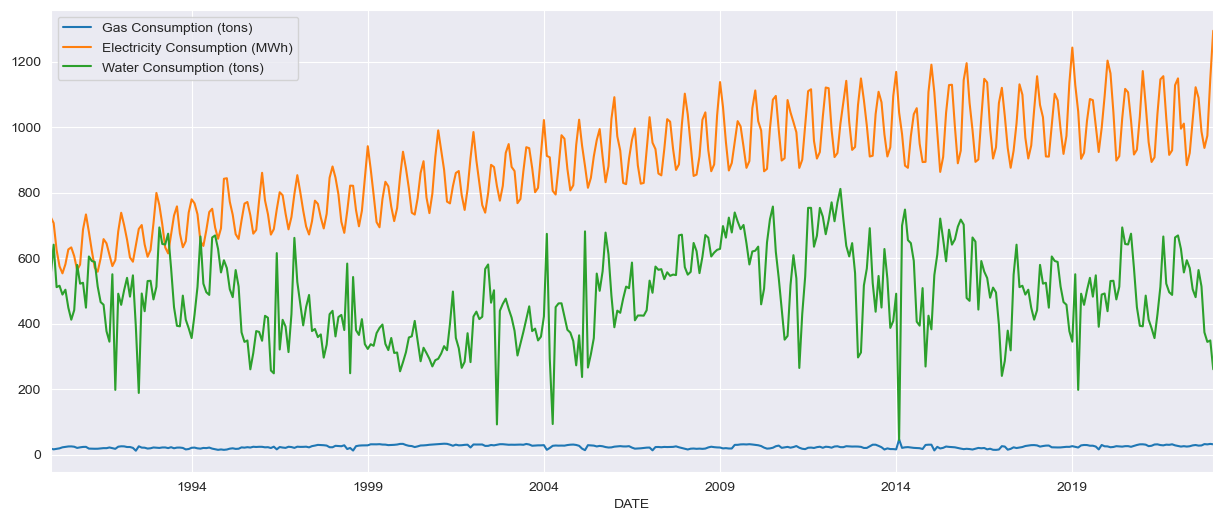

In [13]:
#We can visualize the data and see how it changes over time, as well as identify the trends and patterns in the data.
initialdata.plot(figsize=(15, 6))
plt.show()

### Boxplot 
We can use a boxplot to understand the distribution of the data and identify outliers

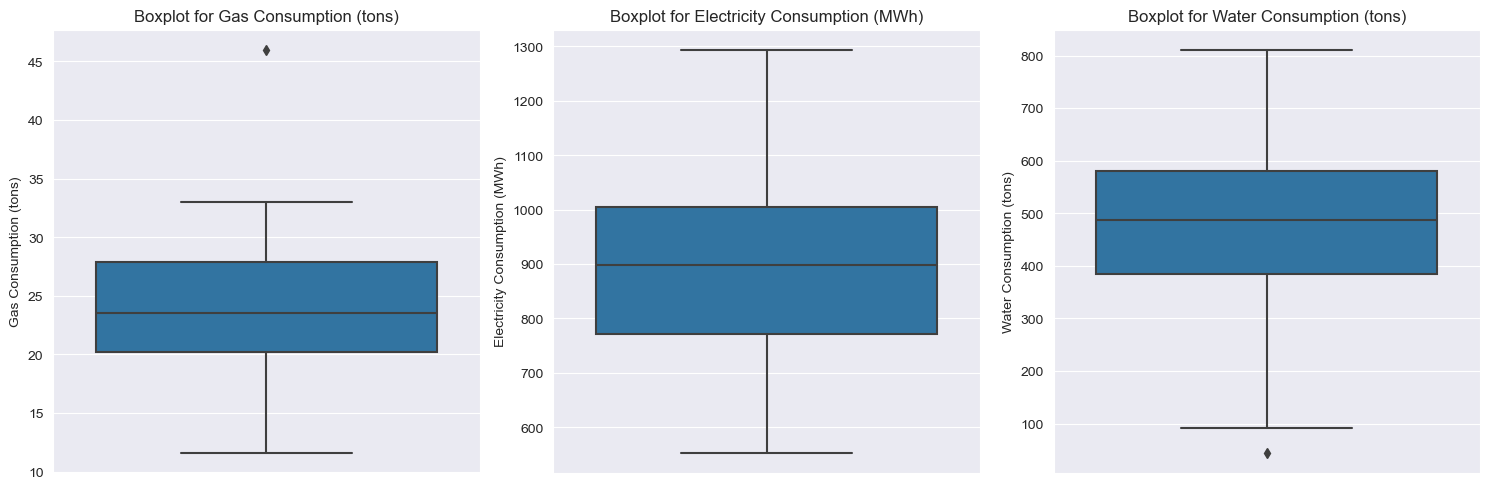

In [14]:
#Using a boxplot to see the distribution of the data and identify outliers

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))



for i, column in enumerate(initialdata.columns):
    sns.boxplot(y=initialdata[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

plt.tight_layout()
plt.show()

### Correlation plot 
In order to see if exgoenous term is needed when training the models, we can look at the correlation between each column. 

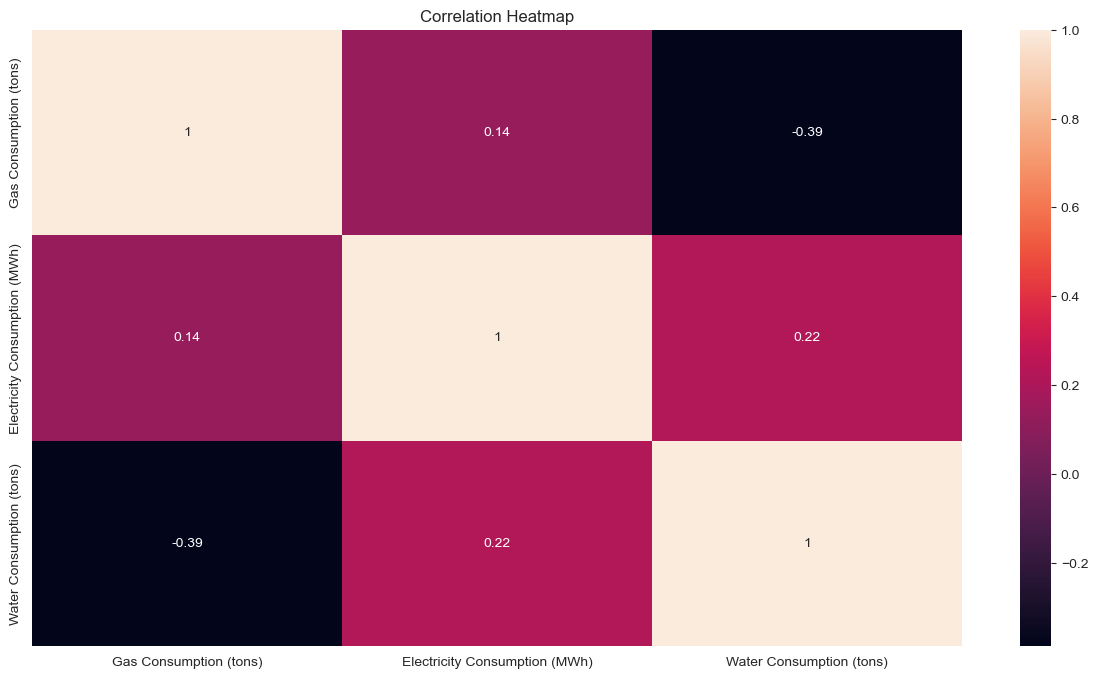

In [15]:
#Correlation plot
sns.heatmap(initialdata.corr(), annot= True)
plt.title("Correlation Heatmap")
plt.show()

#### Correlation Plot Evaluation:

We can see that most of the colummns have a weak to moderate correlation with each other, as these correlations are not really strong enough to consider an exogenous term, i will not be using the exogenous terms for the models later on.

## ADF

The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine if the series is stationary or not.

 Null Hypothesis: The series is non-stationary
 Alternate Hypothesis: The series is stationary.

 For the test to reject the Null hypothesis, probability(p) <= 0.05

In [16]:
#visualize stationality of the dataset using adf

#ADF Test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Fail to reject the null hypothesis. Data is not stationary")

# Apply adf_test on each column
for column in initialdata.columns:
    print(f'Column: {column}')
    adf_test(initialdata[column])
    print('\n')

Column: Gas Consumption (tons)
ADF Statistic: -3.4043743333182785
p-value: 0.010810651707060331
Critical Values:
1%: -3.4472291365835566
5%: -2.8689795375849223
10%: -2.5707330834976987
Reject the null hypothesis. Data is stationary


Column: Electricity Consumption (MWh)
ADF Statistic: -2.256980549592548
p-value: 0.18621802300336432
Critical Values:
1%: -3.4476305904172904
5%: -2.869155980820355
10%: -2.570827146203181
Fail to reject the null hypothesis. Data is not stationary


Column: Water Consumption (tons)
ADF Statistic: -4.684845541682444
p-value: 8.984549388336973e-05
Critical Values:
1%: -3.44714244478345
5%: -2.8689414326247995
10%: -2.5707127699396084
Reject the null hypothesis. Data is stationary




As seen from the output, Electricity Consumption is not Stationary, with a p-value of more than 0.05, this means that an order of differencing is needed to make the data stationary, do note that for ARIMA models, i will be applying the order of differencing directly into the model, while for HWES i will not be applying differencing as it does not require the data to be stationary

## Seasonal Decompostion



Seasonal decomposition for Gas Consumption (tons)
Seasonal_components for Gas Consumption (tons) 12


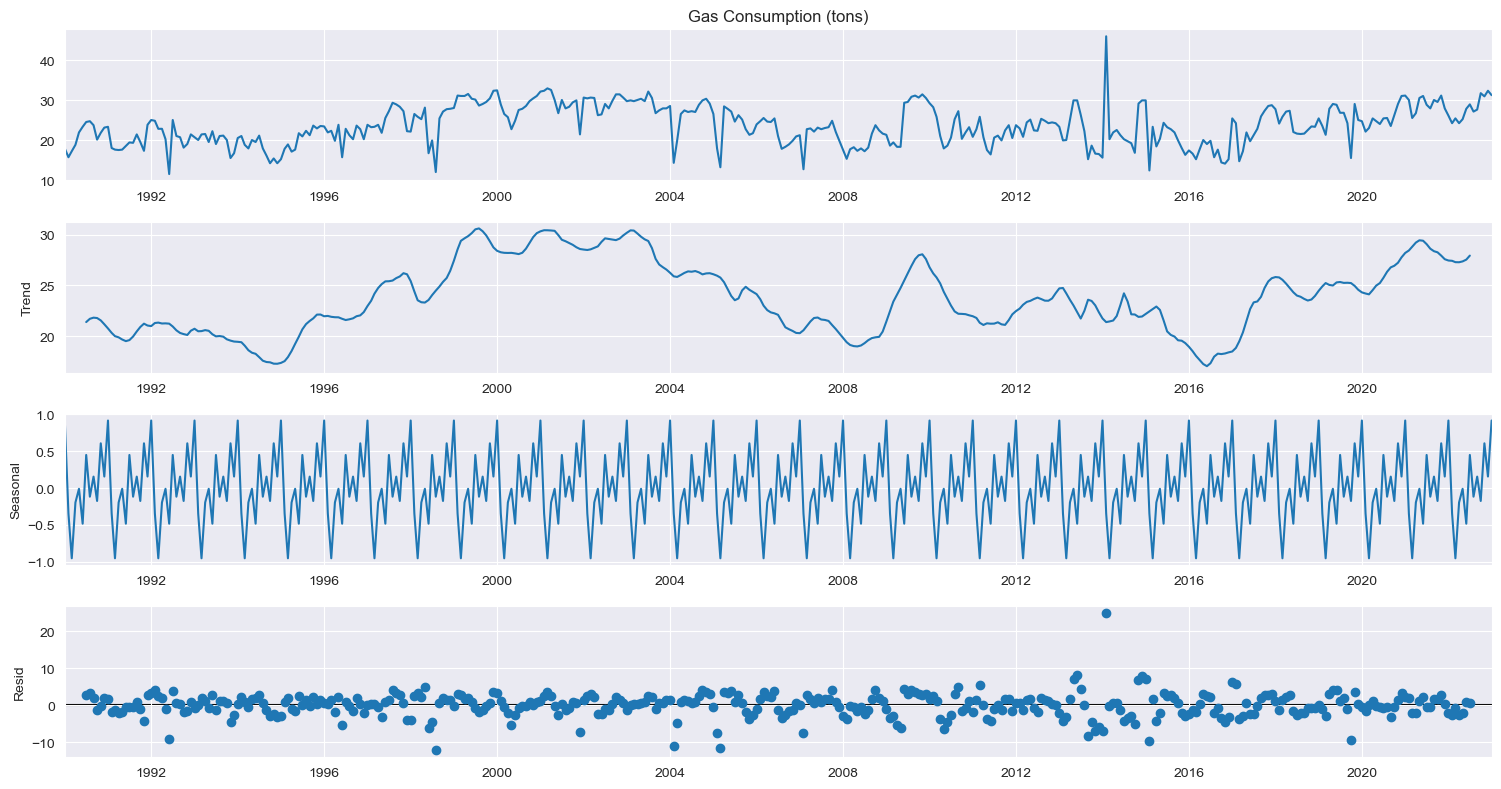

Seasonal decomposition for Electricity Consumption (MWh)
Seasonal_components for Electricity Consumption (MWh) 12


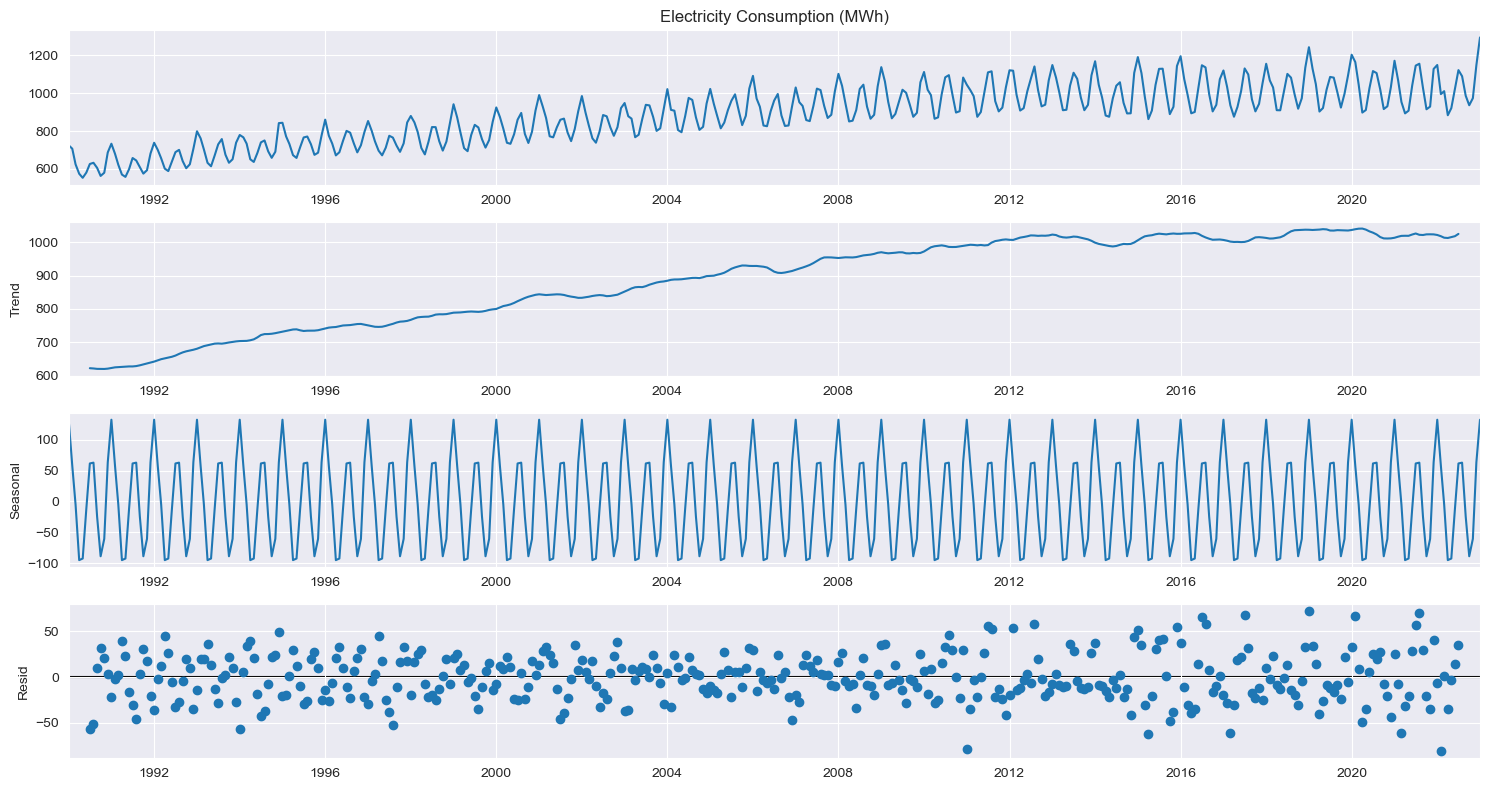

Seasonal decomposition for Water Consumption (tons)
Seasonal_components for Water Consumption (tons) 12


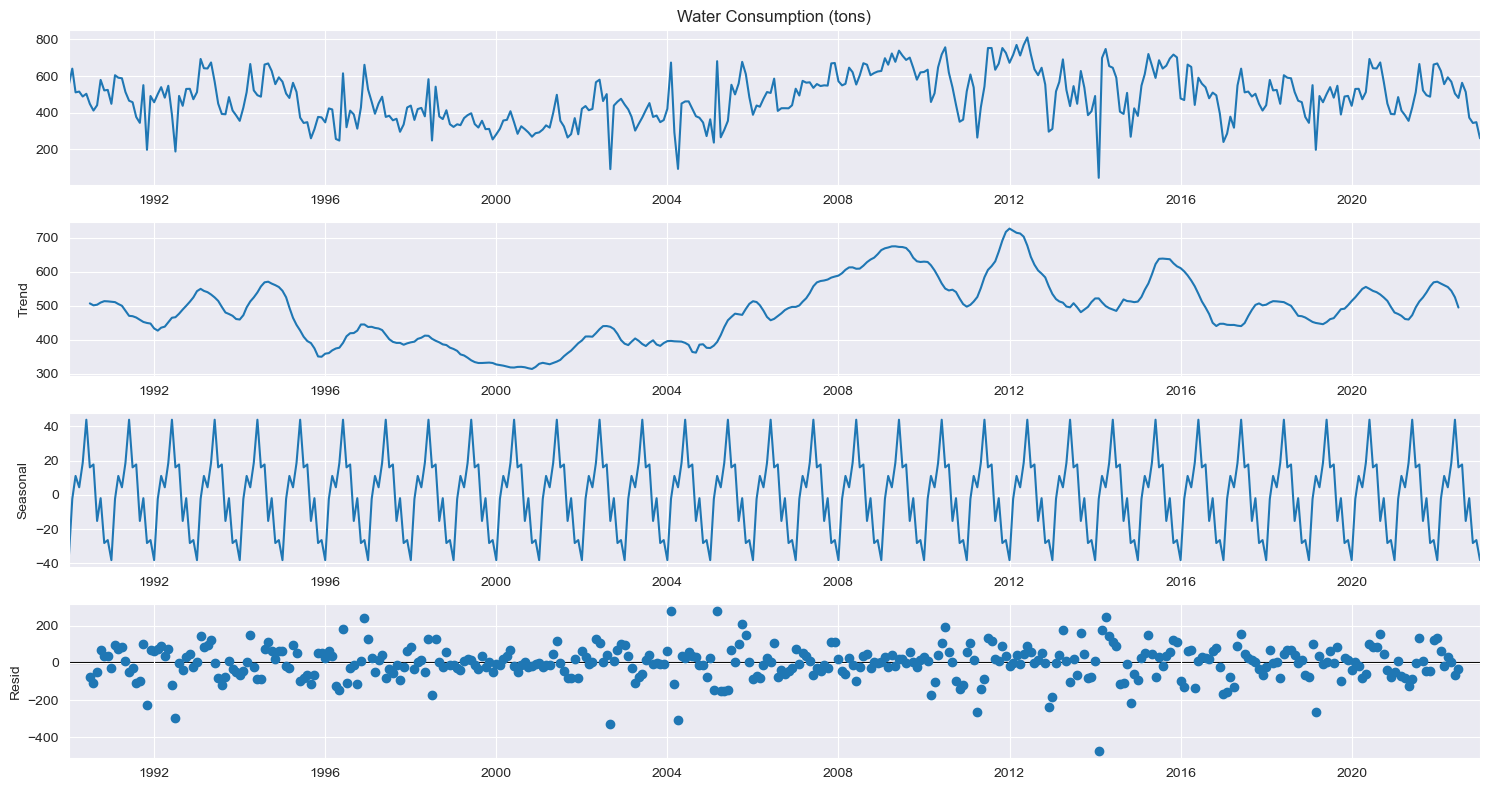

In [17]:
#use seasonal decompose to view the trend, seasonality and noise of the data
season = pd.DataFrame()

initialdata.index = pd.DatetimeIndex(initialdata.index, freq='MS')
#loop through the columns and plot the trend, seasonality and noise for each column
for i in initialdata.columns:
    decomposition = seasonal_decompose(initialdata[i], model='additive')
    fig = decomposition.plot()
    print(f'Seasonal decomposition for {i}')
    season[i] = decomposition.seasonal
    print(f"Seasonal_components for {i}", len(decomposition.seasonal.drop_duplicates()))
    plt.show()

### Gas Seasonal Decomp
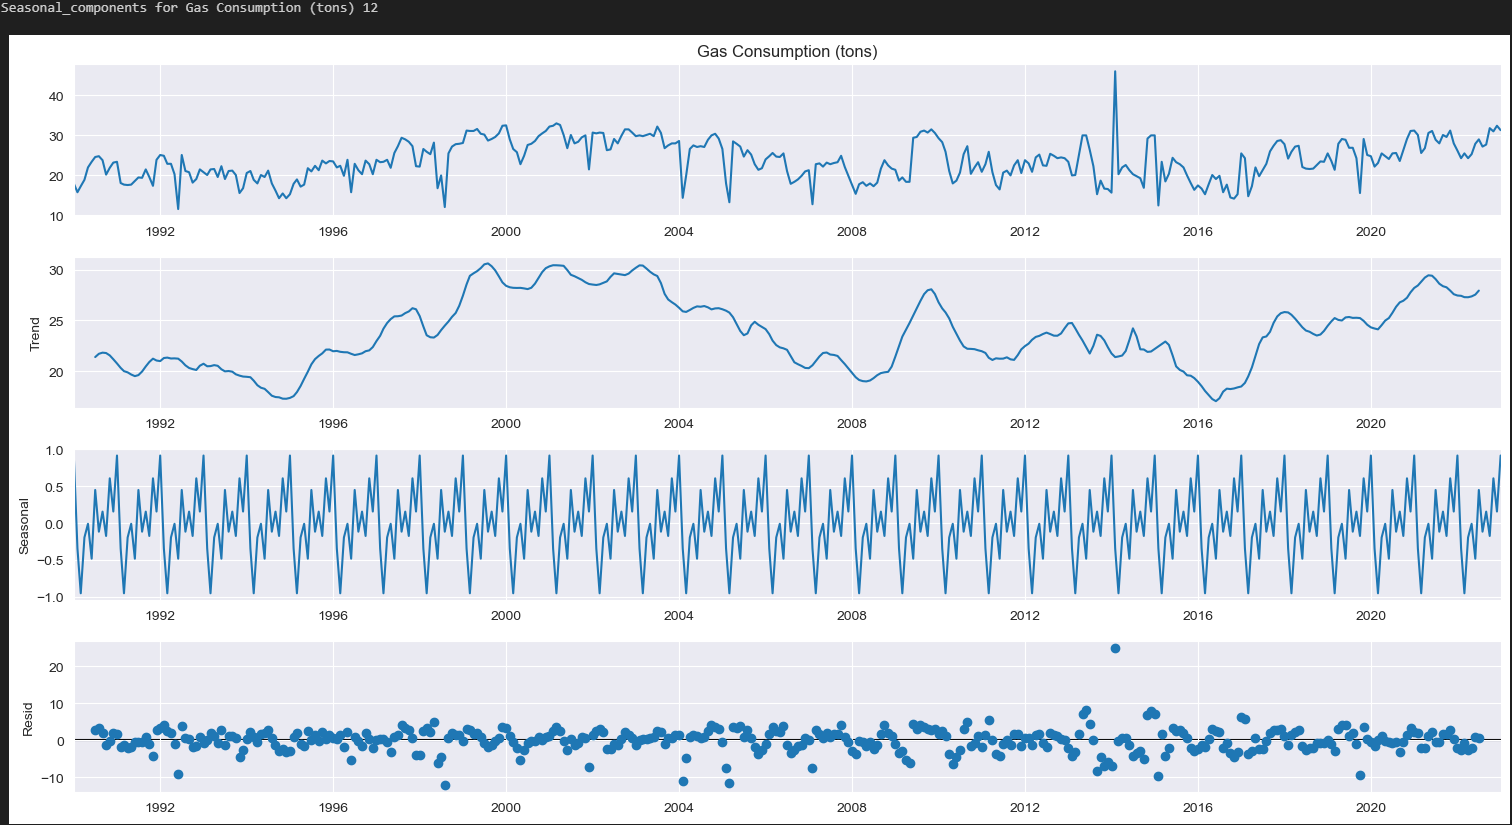


We can see that the gas seasonal decomposition plot has an fluctuating trend, has seasonality as well as residuals close to 0. From the decomposition, we can also identify that the seasonal components is 12

### Electricity Seasonal Decomp
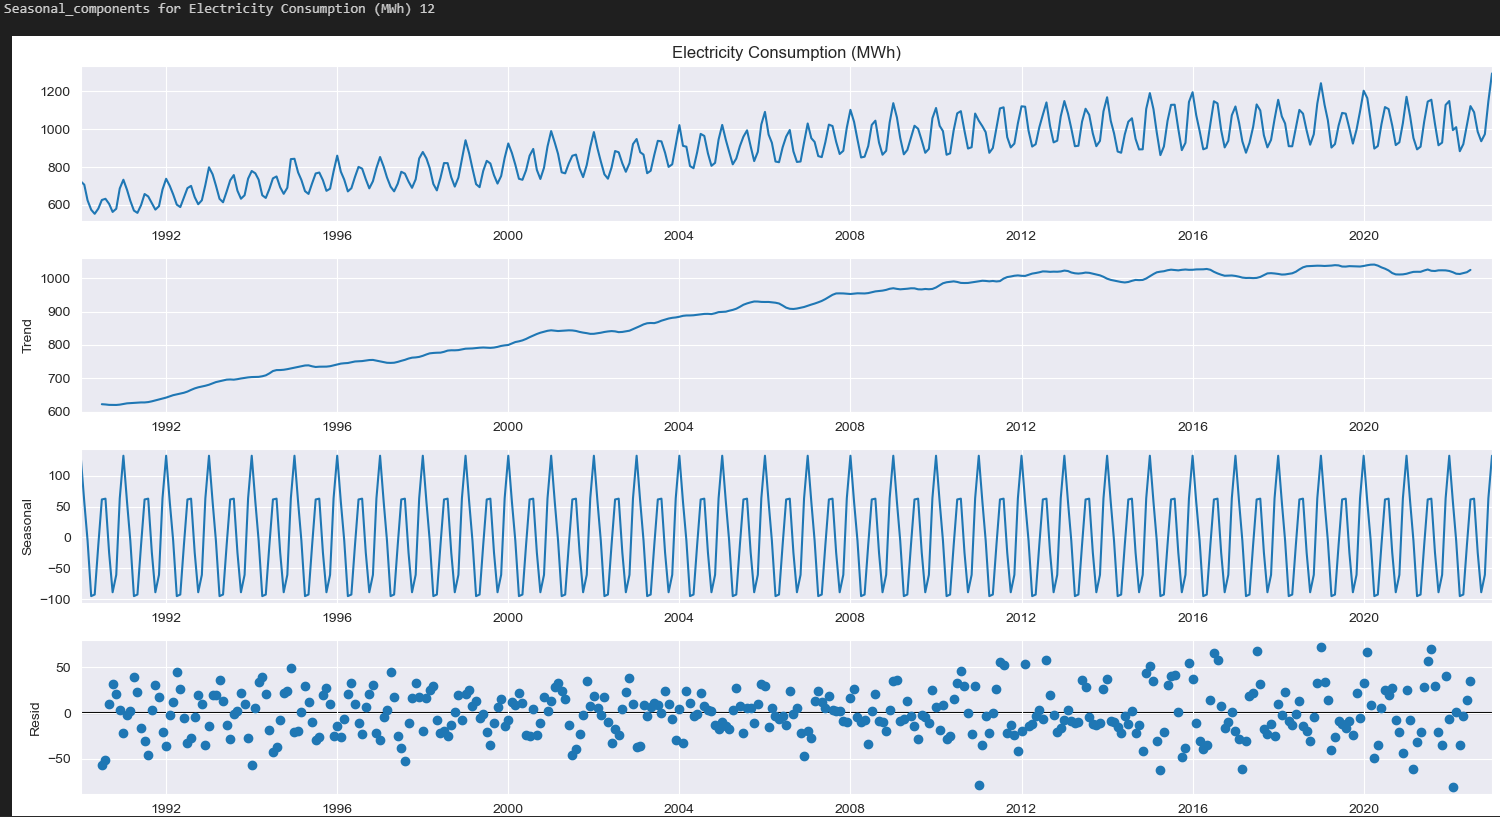


We can see that the Electricity seasonal decomposition plot has an increasing trend, seasonality but residuals that are spread out. From the decomposition, we can also identify that the seasonal components is 12


### Water Seasonal Decomp
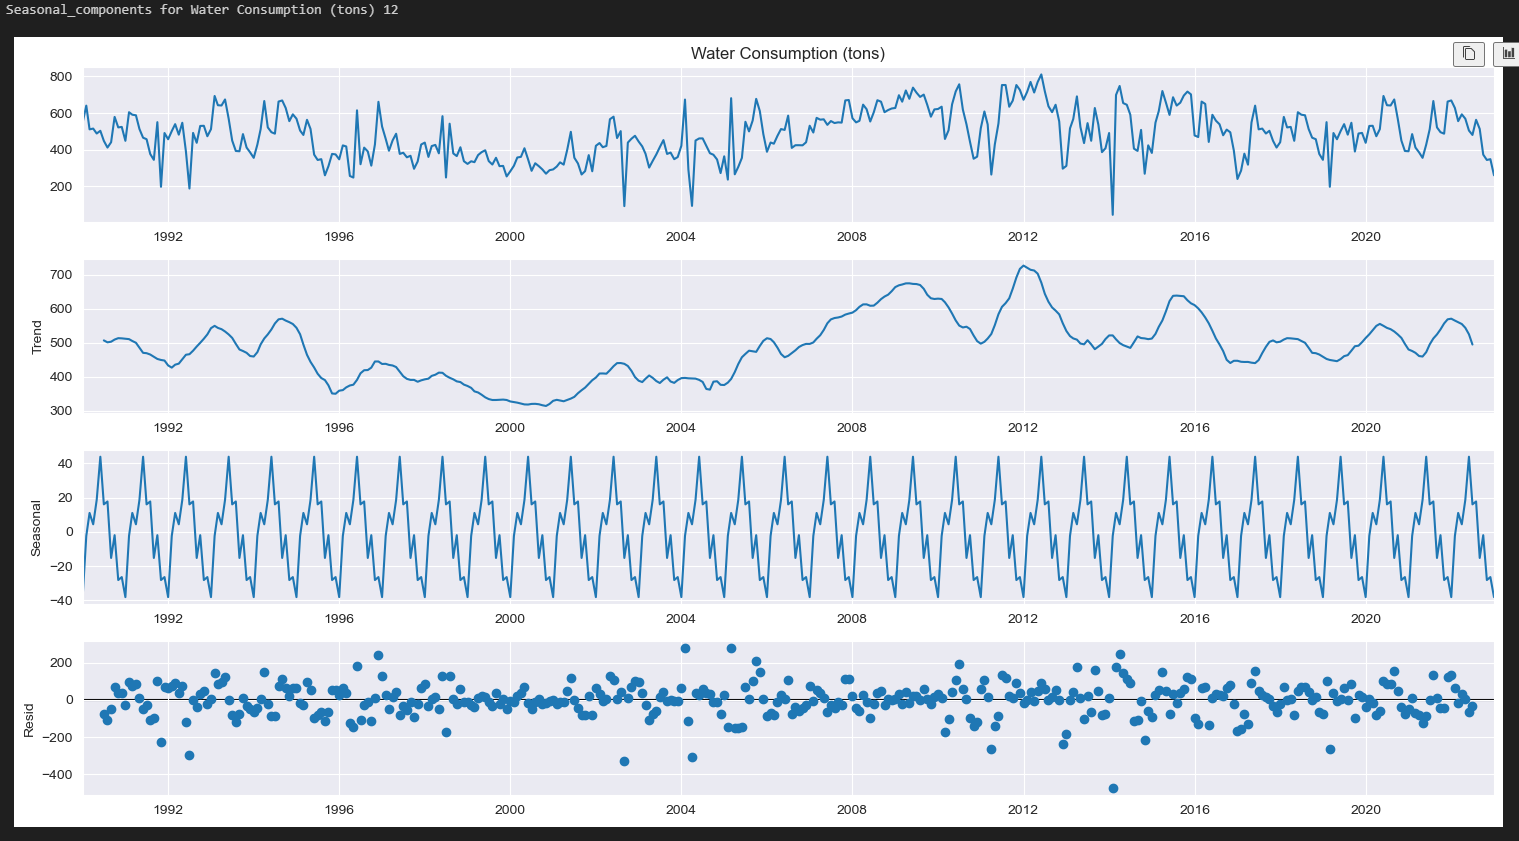


We can see that the water seasonal decomposition plot that there is a fluctuating trend, seasonality as well as residuals that are slightly spread out. From the decomposition, we can also identify that the seasonal components is 12


# Model Fitting

## Evaluation Criteria

For Model Evaluation, we will be using the following metrics (more in depth explanation on these scores later):

### Accuracy Metrics
- Root Mean Squared Error (RMSE): This metric measures the square root of the average of the squared differences between predicted values and actual values. It provides a measure of the model's prediction error in the same units as the target variable.

- Mean Absolute Percentage Error (MAPE): This metric calculates the percentage difference between predicted values and actual values and takes the mean of these absolute percentage errors. It provides a relative measure of the accuracy of the model's predictions.

### Model Complexity Metrics
- Bayesian Information Criterion (BIC): The BIC is a metric used for model selection among a set of candidate models. It penalizes models with more parameters, thus encouraging simpler models. Lower BIC values indicate a better trade-off between model complexity and goodness of fit.

- Akaike Information Criterion (AIC): Similar to BIC, AIC is used for model selection. It also penalizes complex models but with a slightly different formula. Like BIC, lower AIC values suggest better model performance.

### Walk Forward Validation
Walk Forward Validation is a evaluation method that simulates real-world situations where new data becomes available over time. It mimics the process of making predictions on unseen data in a time-dependent manner. This approach helps detect issues such as overfitting or model deterioration as new data is encountered.

By using Walk Forward Validation, we can gain valuable insights into how our model performs with changing data and ensure it remains accurate and reliable over time.


In [18]:
#split the data into train and test sets


def train_test_split_func(data, test_size):
    train, test = train_test_split(data, test_size=test_size, shuffle=False)
    return train, test

train, test = train_test_split_func(initialdata, test_size=0.1)

## Holt Winters Model

is a time series forecasting technique used to make predictions for data with trend and seasonality. It extends the simple exponential smoothing method by incorporating components to handle trends and seasonal variations.

In [19]:
#plot the forecasts

def forecastcompare(forecast, col):
    train[col].plot(figsize=(15, 6), label='Train')
    test[col].plot(label='Test')
    forecast.plot(label='Forecast')
    plt.title(f'Forecast for {col}')
    plt.legend()
    plt.show()

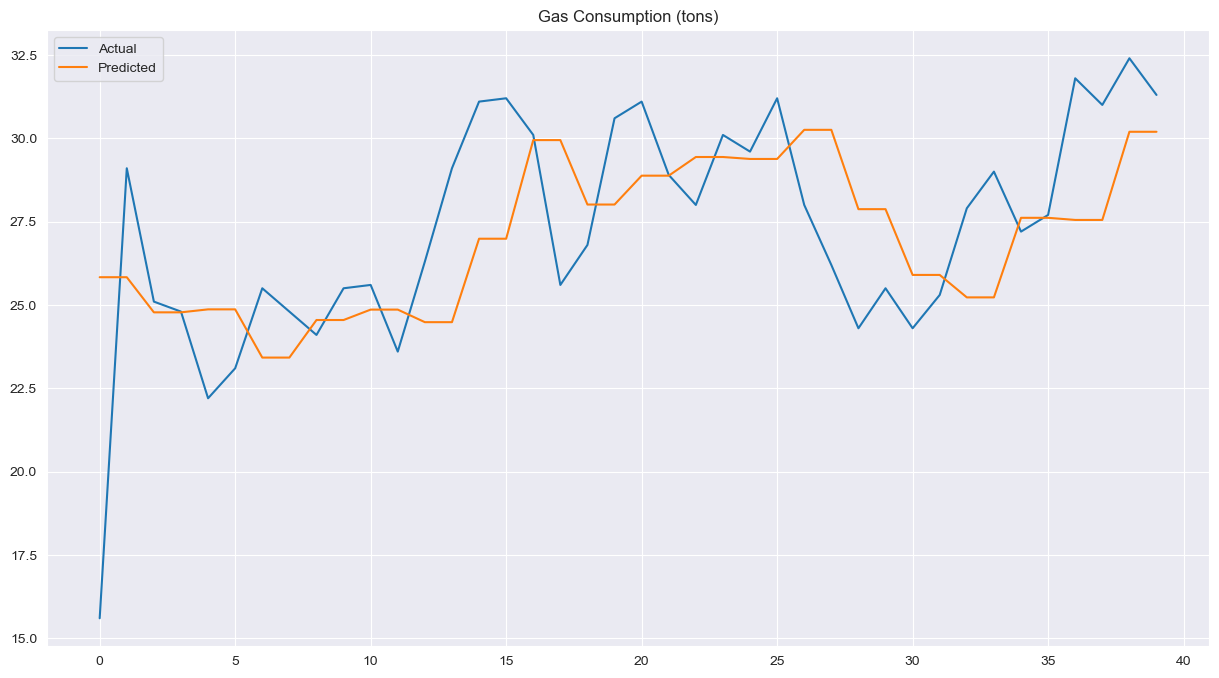

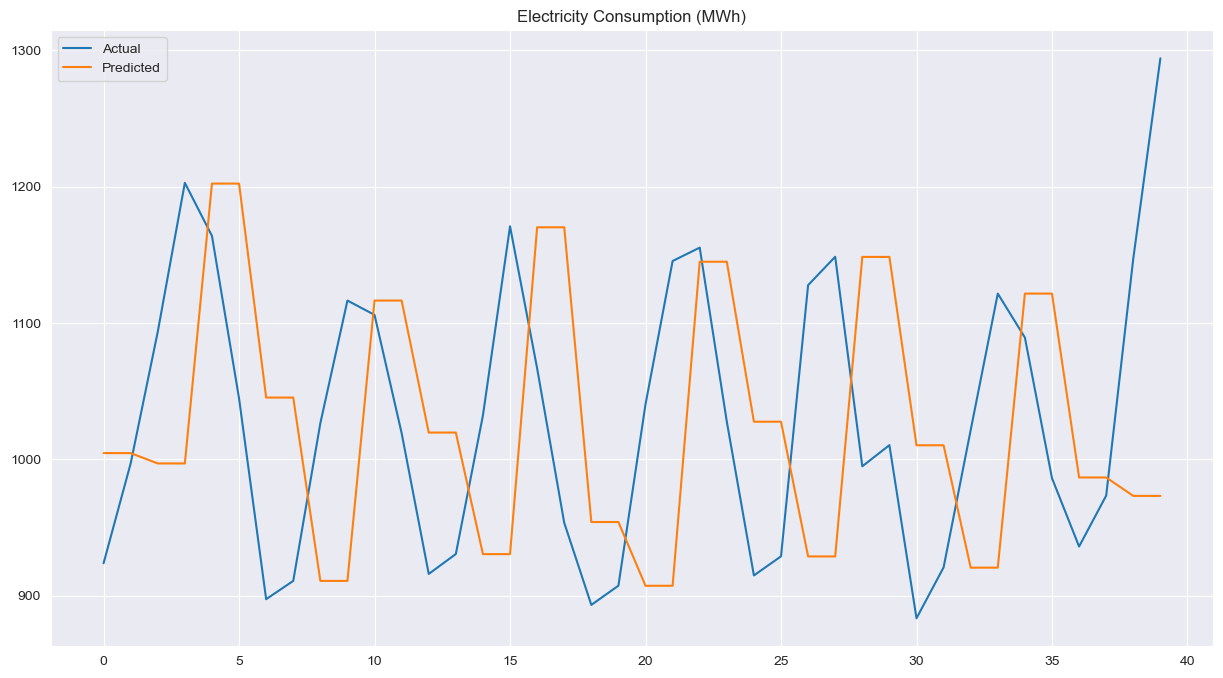

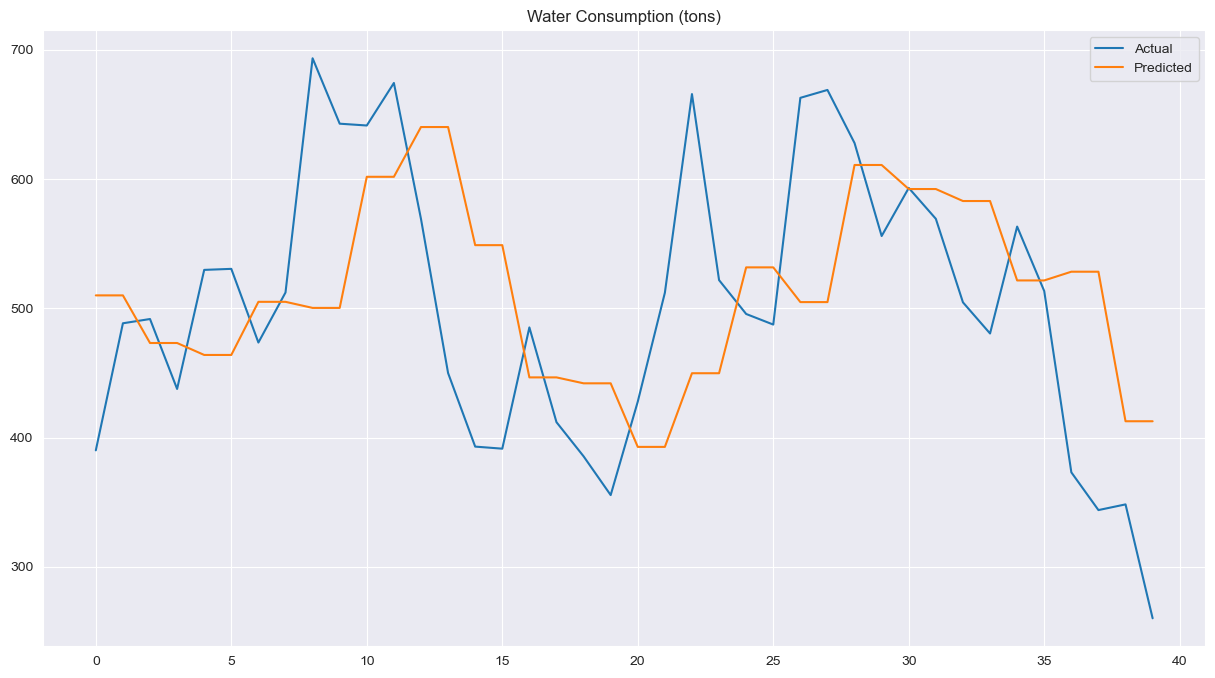

In [20]:
# Initialize an empty DataFrame for results
results = pd.DataFrame()

pred_test_list = pd.DataFrame(columns=train.columns, data = np.zeros((len(test), len(train.columns))))
actuals_test_list = pd.DataFrame(columns=train.columns, data = np.zeros((len(test), len(train.columns))))

step_size = 2  # Number of data points in each step

for i in range(0, len(test), step_size):  # walk forward loop with step size
    for o in train.columns:  # column loop
        train_data = pd.concat([train, test[:i]])
        model = HWES(train_data[o], seasonal_periods=12)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=step_size)
        pred_test_list.loc[i:i + step_size - 1, o] = list(forecast)
        actuals_test_list.loc[i:i + step_size - 1, o] = list(test[o][i:i + step_size])

# Calculate metrics and results
for i in range(0, len(test), step_size):
    for o in train.columns:
        pred_test = np.array(pred_test_list[o][:i + step_size])  # Consider predictions up to the current step
        actuals_test = np.array(actuals_test_list[o][:i + step_size])  # Consider actual test data up to the current step
        RMSE = mean_squared_error(actuals_test, pred_test, squared=False)
        MAPE = mean_absolute_percentage_error(actuals_test, pred_test)
        aic = model_fit.aic
        bic = model_fit.bic
        result = pd.DataFrame({'Column': o, 'Model': 'HWES', 'AIC': aic, 'BIC': bic, 'RMSE': RMSE, 'MAPE': MAPE}, index=[0])
        results = results.append(result, ignore_index=True)


for i in actuals_test_list.columns:
    plt.plot(actuals_test_list[i], label='Actual')
    plt.plot(pred_test_list[i], label='Predicted')
    plt.title(i)
    plt.legend()
    plt.show()

average_scores = results.groupby('Column').mean().reset_index()
sorted_results = average_scores.sort_values(by=['Column', 'AIC', 'BIC', 'RMSE', 'MAPE'])
sorted_results['Model'] = 'HWES'
results = sorted_results


### Walk forward explanation:

- Outer Loop (for i loop): This loop goes through different testing steps. In each step, you're checking how well your model performs.

- Inner loop: loops through the columns

- Append Test to Train: After each step, take the data you used for testing and add it to the data you used for training the model. This is like giving the model more information to learn from.

This simple alternate evaluation method is basically time series' version of k fold validation, which allows us to see how well the model performs on the **whole** dataset

## Auto ARIMA

is an automated time series forecasting model that automatically selects the optimal parameters for an ARIMA model. 


We can use Auto ARIMA to gain a rough understanding on the parameters for the ARIMA model



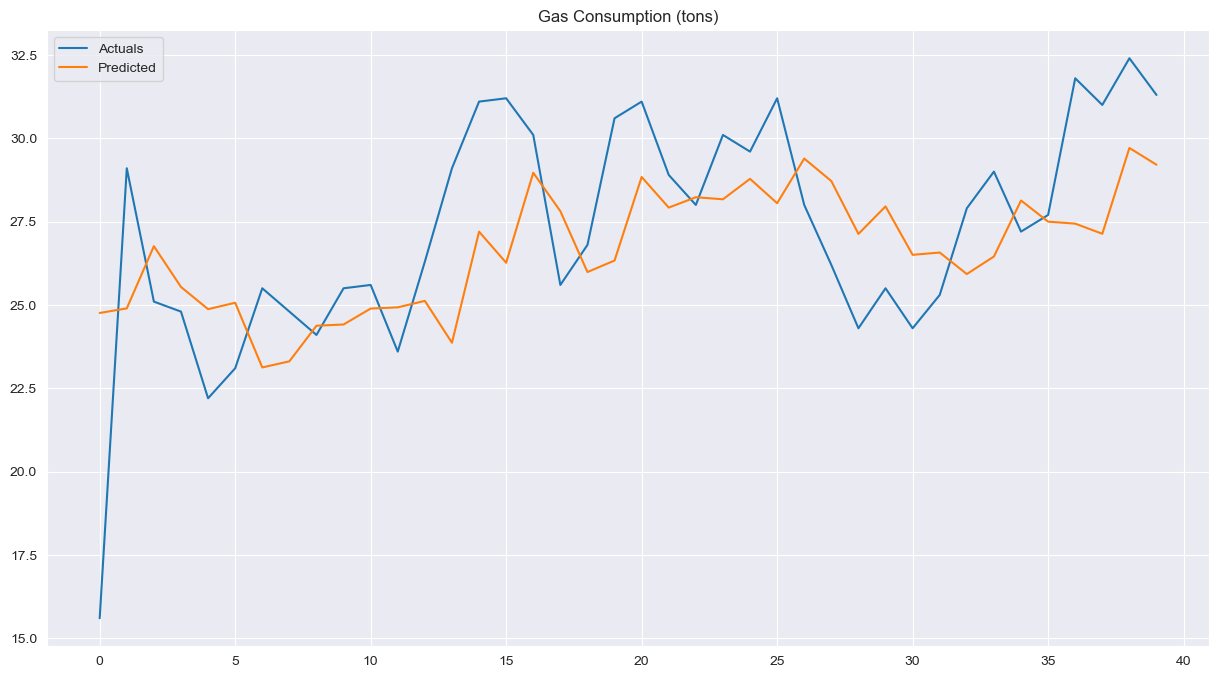

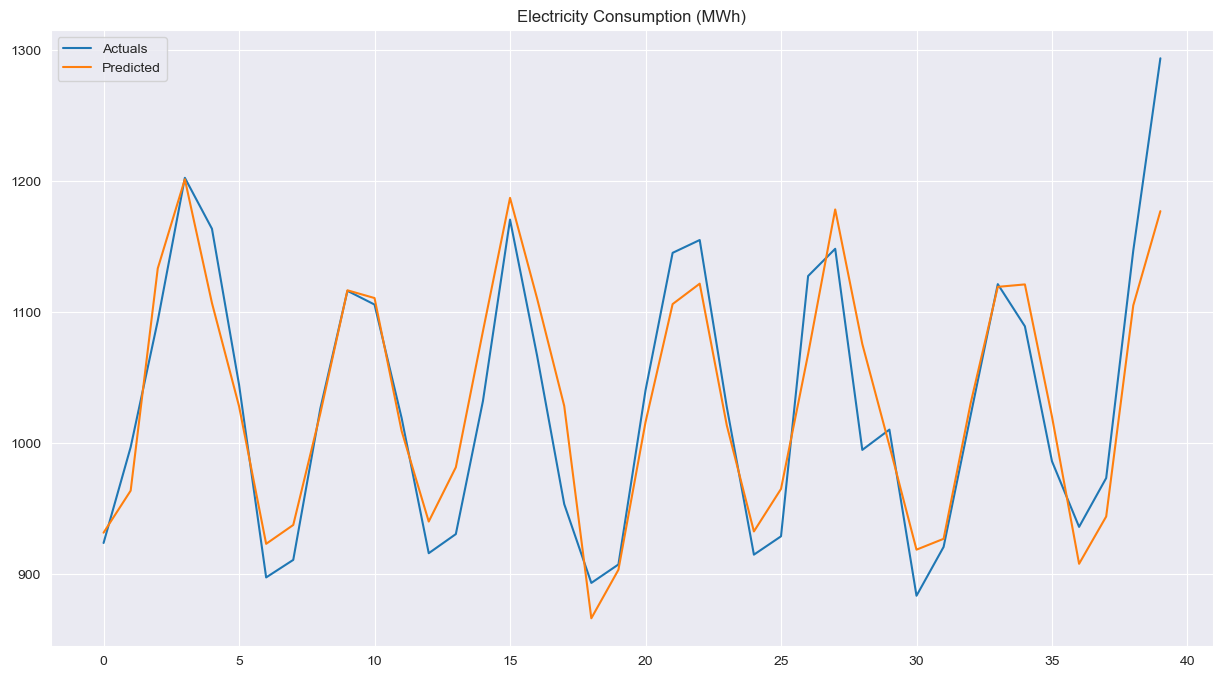

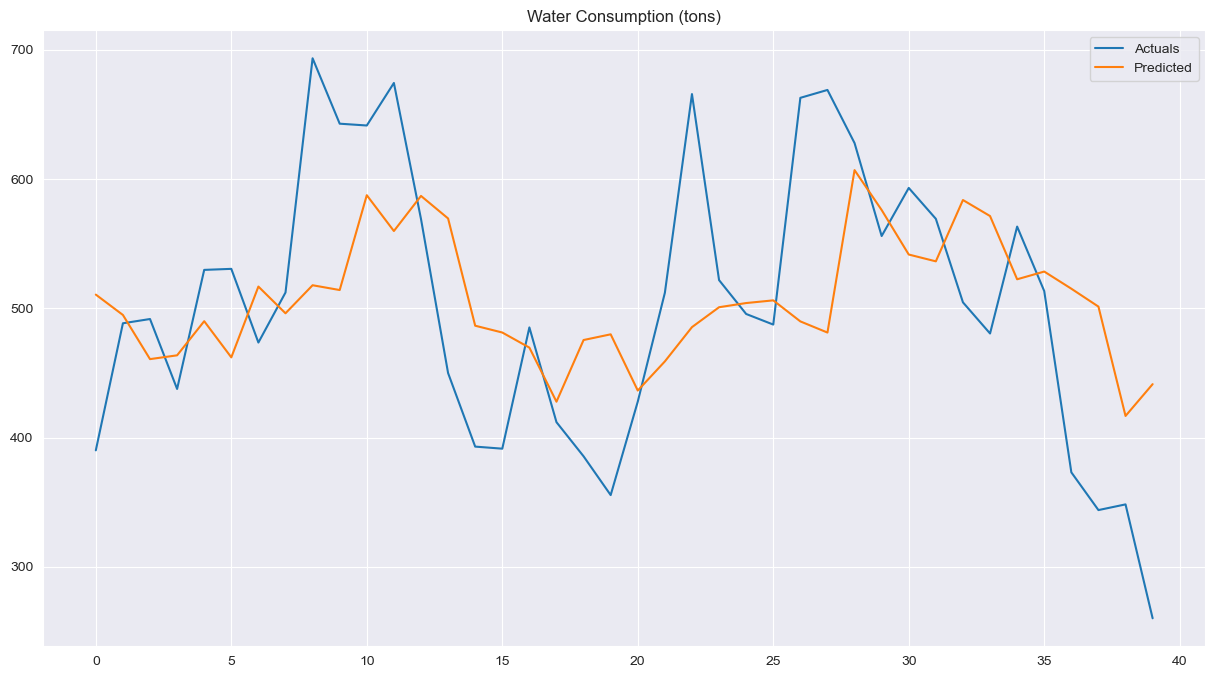

In [21]:
#auto arima model

pred_test_list = pd.DataFrame(columns=train.columns, data = np.zeros((len(test), len(train.columns))))
actuals_test_list = pd.DataFrame(columns=train.columns, data = np.zeros((len(test), len(train.columns))))
step_size = 2

#forecast the data using auto arima
for col in train.columns:

    #fit the model
    model = auto_arima(train[col], seasonal=True, m=12, suppress_warnings=True)



    for i in range(0, len(test), step_size):  # walk forward loop with step size
        train_data = pd.concat([train, test[:i]])
        model_fit = model.fit(train_data[col])
        pred_test_list.loc[i:i + step_size - 1, col] = list(model_fit.predict(n_periods=step_size))  # Use predict method for step size
        actuals_test_list.loc[i:i + step_size - 1, col] = list(test[col][i:i + step_size])  # Use the corresponding range of actuals

        pred_test = np.array(pred_test_list[col][:i + step_size])  # Consider predictions up to the current step
        actuals_test = np.array(actuals_test_list[col][:i + step_size])  # Consider actual up to the current step

        RMSE = mean_squared_error(actuals_test, pred_test, squared=False)
        MAPE = mean_absolute_percentage_error(actuals_test, pred_test)
        aic = model_fit.aic()
        bic = model_fit.bic()

        result = pd.DataFrame({'Column': col, 'Model': 'Auto ARIMA', 'AIC': aic, 'BIC': bic, 'RMSE': RMSE, 'MAPE': MAPE}, index=[0])
    temp = result.mean().reset_index()
    temp = temp.append(result, ignore_index=True)
    temp['Model'] = 'Auto ARIMA'
    results = results.append(temp[['Column', 'Model', 'AIC', 'BIC', 'RMSE', 'MAPE']].dropna(), ignore_index=True)
    plt.plot(actuals_test, label='Actuals')
    plt.plot(pred_test, label='Predicted')
    plt.title(col)
    plt.legend()
    plt.show()

## ARIMA

ARIMA is a widely used approach for such forecasting tasks, and it stands for AutoRegressive Integrated Moving Average.

In order to identify the parameters for the model, we can analyse ACF and PACF plots

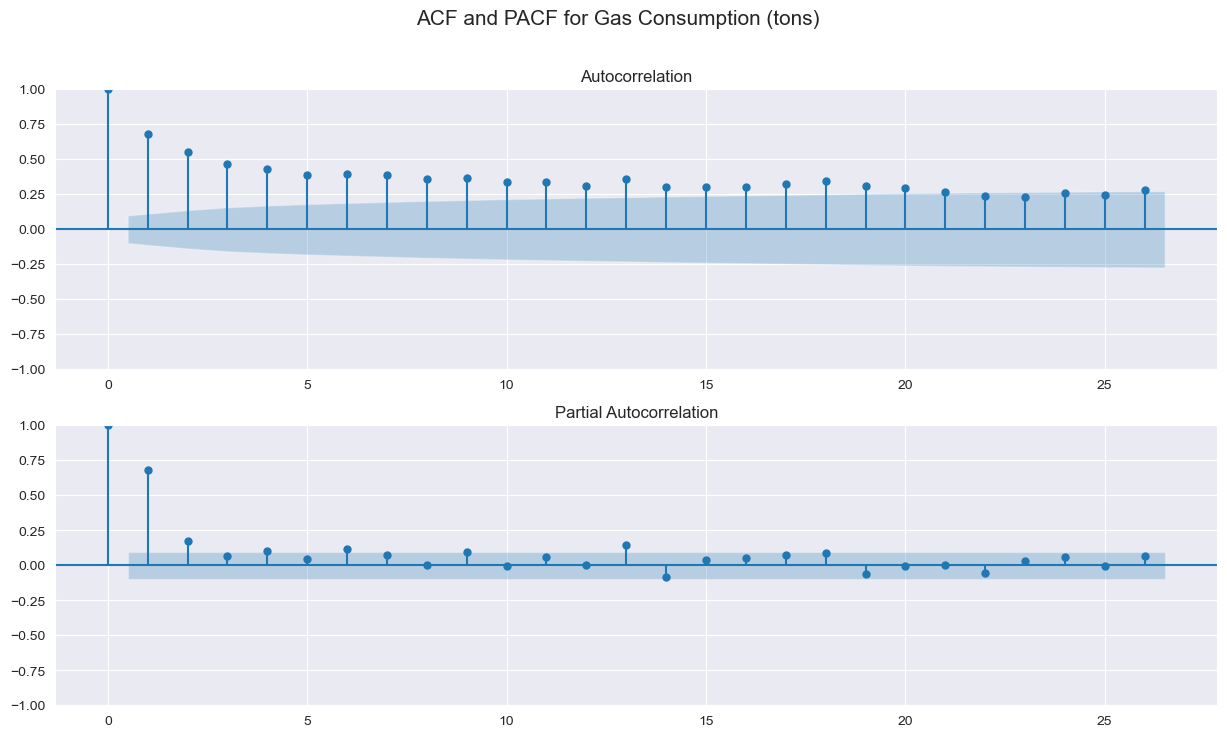

In [22]:
#plot the acf and pacf to determine the parameters for the ARIMA model

fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle(f'ACF and PACF for Gas Consumption (tons)', fontsize=15)
plot_acf(initialdata['Gas Consumption (tons)'], ax=ax[0], )
plot_pacf(initialdata['Gas Consumption (tons)'], ax=ax[1])
plt.show()

### ACF PACF Evaluation for Gas Consumption

- The "suspension bridge" pattern in the ACF is typical of a series that is both nonstationary and strongly seasonal. 
We will need at least one order of differencing







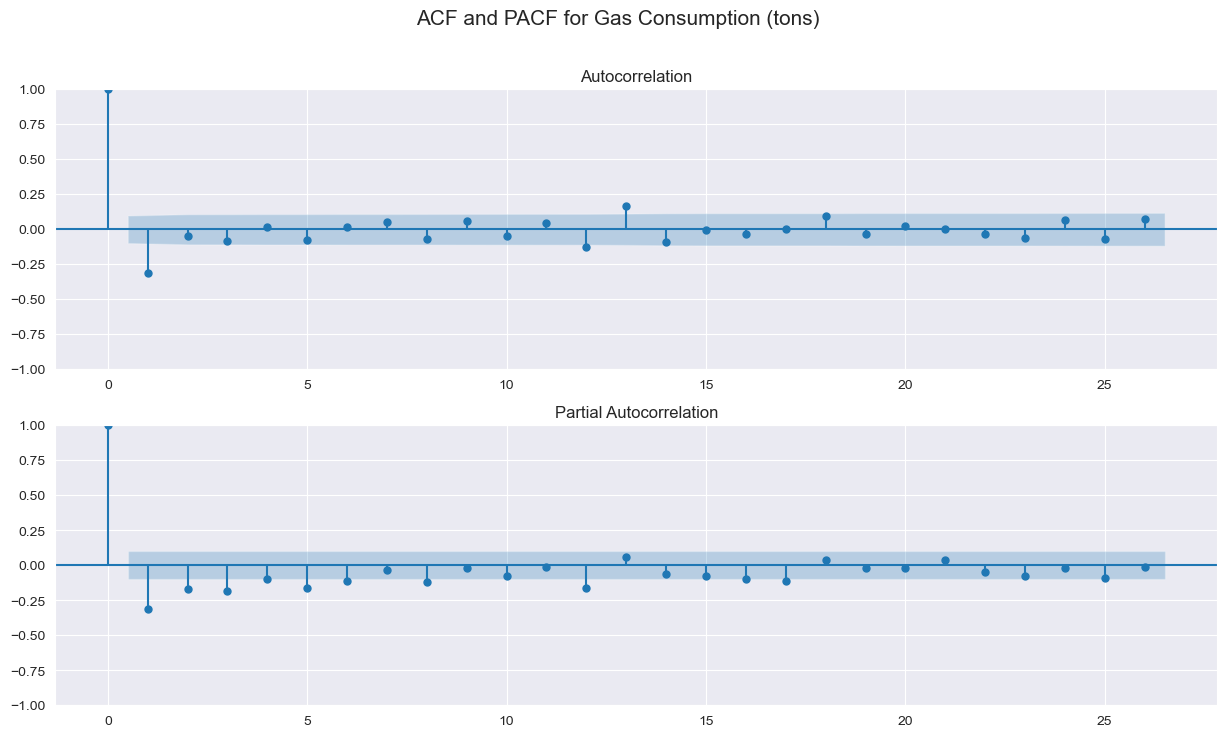

In [23]:
def differencing(series, interval=1):
    diff_series = diff(series, k_diff=interval).dropna()
    return diff_series

# Apply differencing function on the Gas column
gas_diff = differencing(initialdata['Gas Consumption (tons)'], interval=1)

#plot the ACF and PACF for the differenced data
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle('ACF and PACF for Gas Consumption (tons)', fontsize=15)
plot_acf(gas_diff, ax=ax[0], )
plot_pacf(gas_diff, ax=ax[1])
plt.show()

<div style="border-top: 2px solid #ADD8E6; margin-top: 20px;"></div>

#### Evaluation After Differencing of Gas Column

Identifying the number of terms for ARIMA Model:

We can see that lag-1 for the ACF is negative, as well as the fact that ACF displays a cutoff while PACF displays a tail off. Based on this, we can conclude that an MA model is suitable for Gas Consumption. As the cutoff occurs at lag-1, we can consider an MA(1) model.

<div style="border-top: 1px dashed #999; margin-top: 10px;"></div>

Seasonal trend:

We can see that there are slight spikes in both the ACF and the PACF at lag-12. This suggests a seasonal period of 12. As the spikes are not strong and consistent, I will not be applying an order of seasonal differencing. Since lag-12 is negative on the ACF, we can consider an SMA term for the model, with the number of terms being 1 (SMA(1)). However, as the lag spike is weak i will also be fitting an ARIMA model without a seasonal order.

<div style="border-top: 1px dashed #999; margin-top: 10px;"></div>

The final model(s) to be considered for the gas column will be ARIMA(0,1,1)x(0,0,1) and ARIMA(0,1,1).

<div style="border-top: 2px solid #ADD8E6; margin-top: 20px;"></div>


### Electricity ACF PACF 

Recall that we identified that an order of differencing was needed for the electricity column in the ADF test, we will apply it now and read the ACF and PACF for the differenced data

In [24]:
# Apply diff() function on Electricity column
elect_diffed = diff(initialdata['Electricity Consumption (MWh)'], k_diff=1)

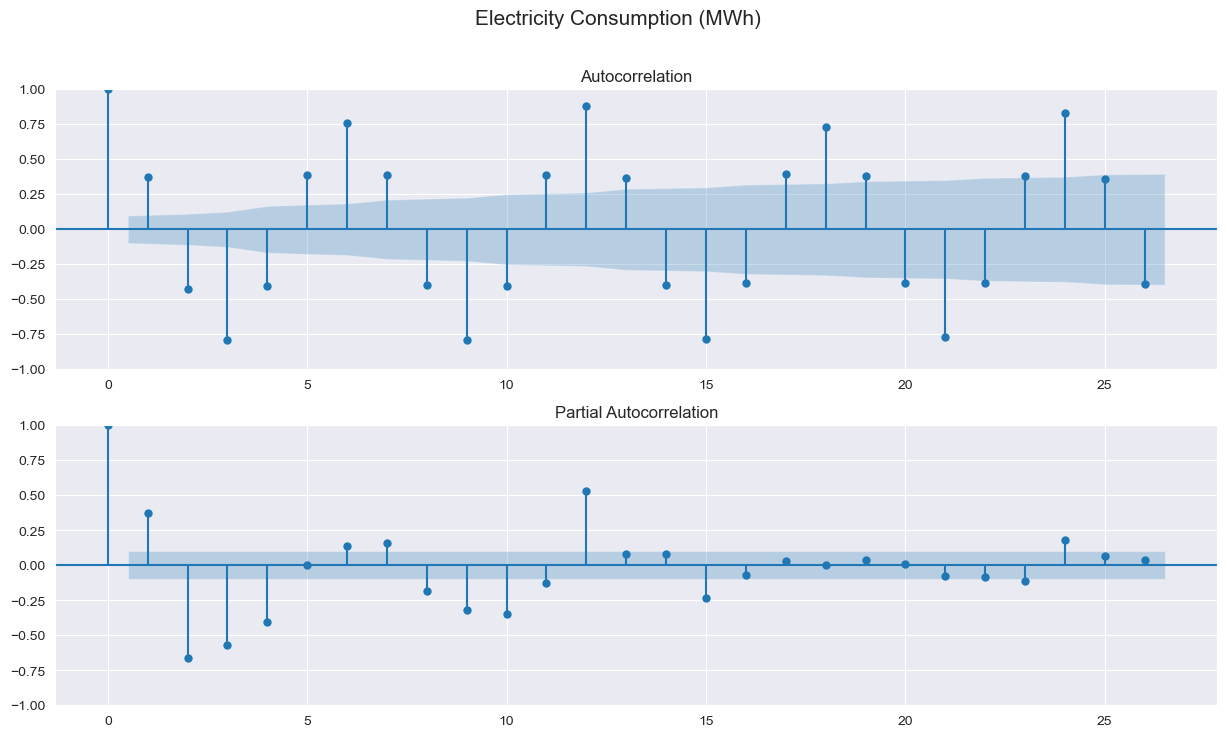

In [25]:
#plot the acf and pacf to determine the parameters for the ARIMA model

fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle(f'Electricity Consumption (MWh)', fontsize=15)
plot_acf(elect_diffed, ax=ax[0], )
plot_pacf(elect_diffed, ax=ax[1])
plt.show()

#### ACF PACF Evaluation for Electricity Consumption

- From Lag 12 and Lag 24 We can see that the ACF and PACF has a strong and consistent seasonal pattern, an order of seasonal differencing should be applied







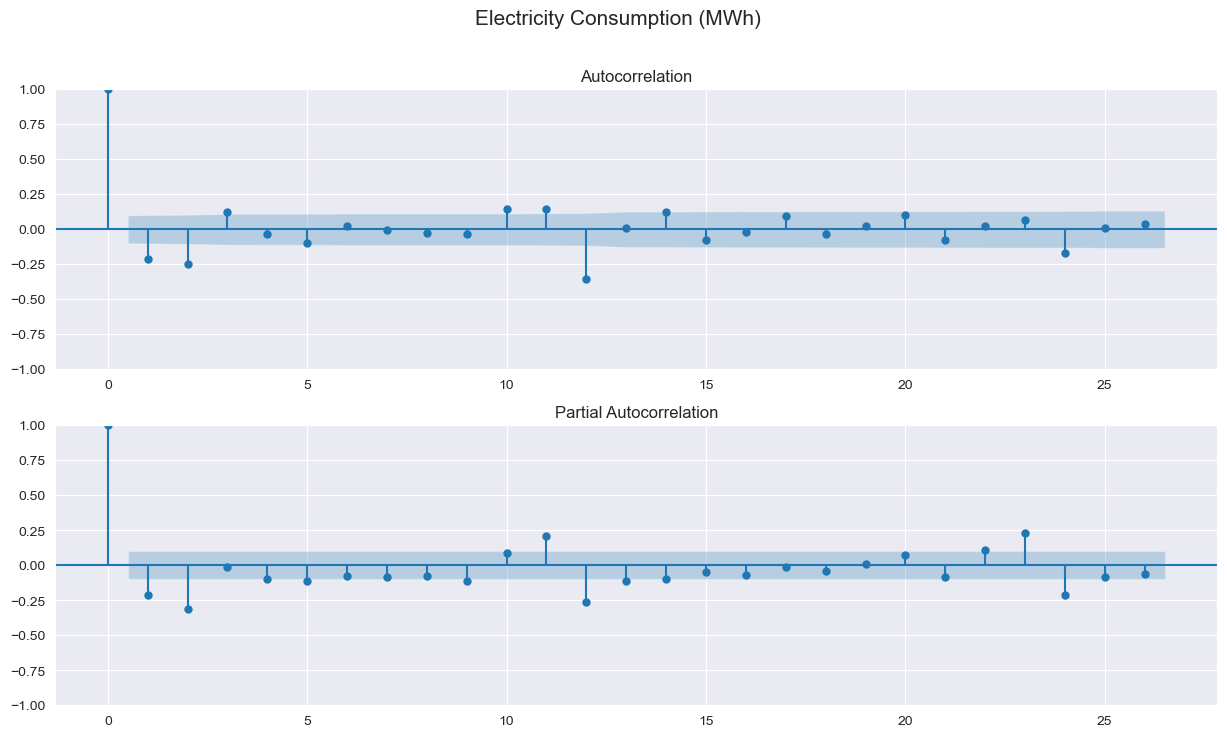

In [26]:
# Apply differencing function on the Electricity column
electricity_diff = diff(elect_diffed,k_diff=0, k_seasonal_diff=1, seasonal_periods=12)

#plot the ACF and PACF for the differenced data
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Electricity Consumption (MWh)', fontsize=15)
plot_acf(electricity_diff, ax=ax[0])
plot_pacf(electricity_diff, ax=ax[1])
plt.show()

<div style="border-top: 2px solid #ADD8E6; margin-top: 20px;"></div>

#### Evaluation After Differencing of Electricity Column

Identifying the number of terms for ARIMA Model:

We can see that lag-1 for the ACF is negative, however the cut off/tail off of the plots can not be easily discerned, therefore i will be considering both an AR and a MA model for this column. 
For the number of terms we can look at the cut offs for PACF for AR and ACF for MA, number of terms for AR would be 2, while the number of terms for MA would be 3.

<div style="border-top: 1px dashed #999; margin-top: 10px;"></div>

Seasonal trend:

Since lag-12 is negative on the ACF, we can consider an SMA term for the model, with the number of terms being 1 (SMA(1)).


<div style="border-top: 1px dashed #999; margin-top: 10px;"></div>

The final model(s) to be considered for the electricity column will be ARIMA(0,1,3)x(0,1,1) and ARIMA(2,1,0)x(0,1,1).



(Note that an order of non-seasonal differencing was applied previously during the ADF test)

<div style="border-top: 2px solid #ADD8E6; margin-top: 20px;"></div>


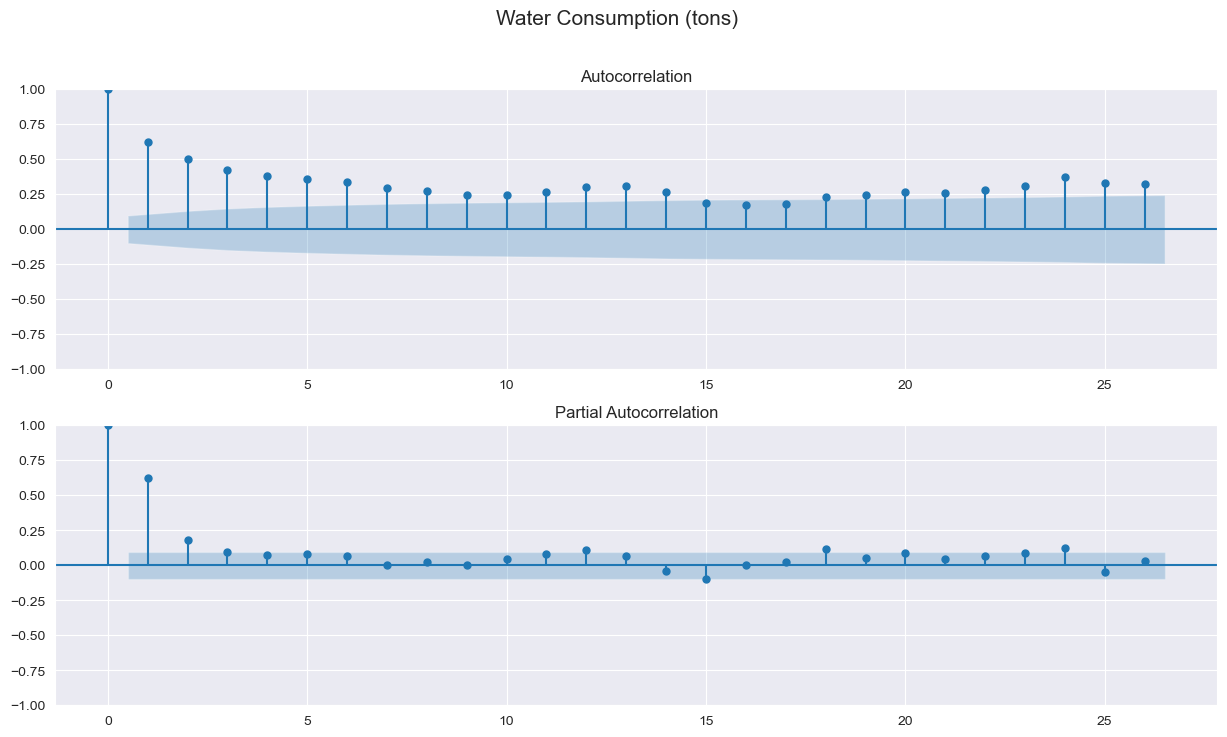

In [27]:
#plot the acf and pacf to determine the parameters for the ARIMA model

fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle(f'Water Consumption (tons)', fontsize=15)
plot_acf(initialdata['Water Consumption (tons)'], ax=ax[0], )
plot_pacf(initialdata['Water Consumption (tons)'], ax=ax[1])
plt.show()

### Evaluation of ACF and PACF for water consumption

The first thing we notice about the ACF and PACF for this column is that the ACF has a suspension bridge pattern, we should apply an order of differencing.

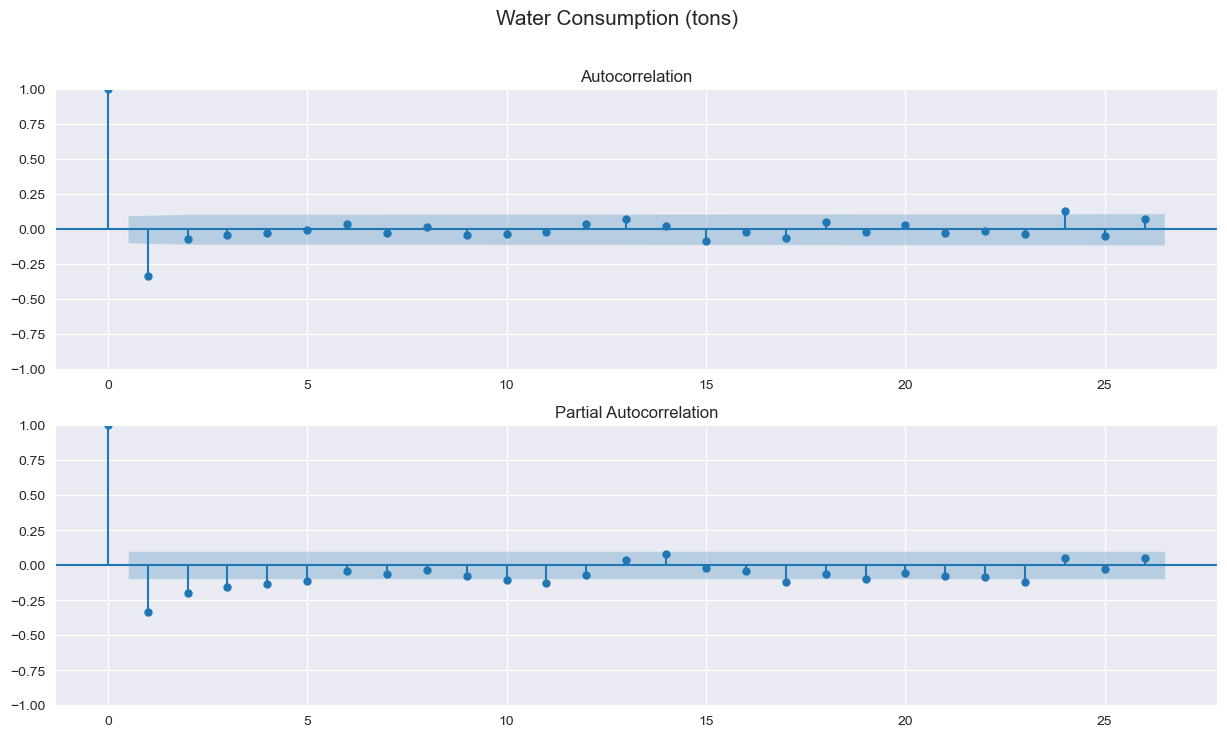

In [28]:
#apply differencing function on the water column

water_diff = differencing(initialdata['Water Consumption (tons)'], interval=1)

#plot new ACF and PACF 

fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Water Consumption (tons)', fontsize=15)
plot_acf(water_diff, ax=ax[0])
plot_pacf(water_diff, ax=ax[1])
plt.show()



<div style="border-top: 2px solid #ADD8E6; margin-top: 20px;"></div>

#### Evaluation After Differencing of Water Consumption Column

Identifying the number of terms for ARIMA Model:

We can see that lag-1 for the ACF is negative, as well as the fact that PACF tails off and ACF cuts off, therefore a MA model would be more suited for this column. To identify the number of terms to use, we can look at where the lag cuts off for the ACF plot. I will be using a MA(1) as ACf cuts off at lag 1.

<div style="border-top: 1px dashed #999; margin-top: 10px;"></div>

Seasonal trend:

There is no discernable seasonanl trend from the ACF and PACF, therefore i will not be applying an order of seasonal differencing and using seasonal order.


<div style="border-top: 1px dashed #999; margin-top: 10px;"></div>

The final model(s) to be considered for the water consumption column will be ARIMA(0,1,1)



<div style="border-top: 2px solid #ADD8E6; margin-top: 20px;"></div>


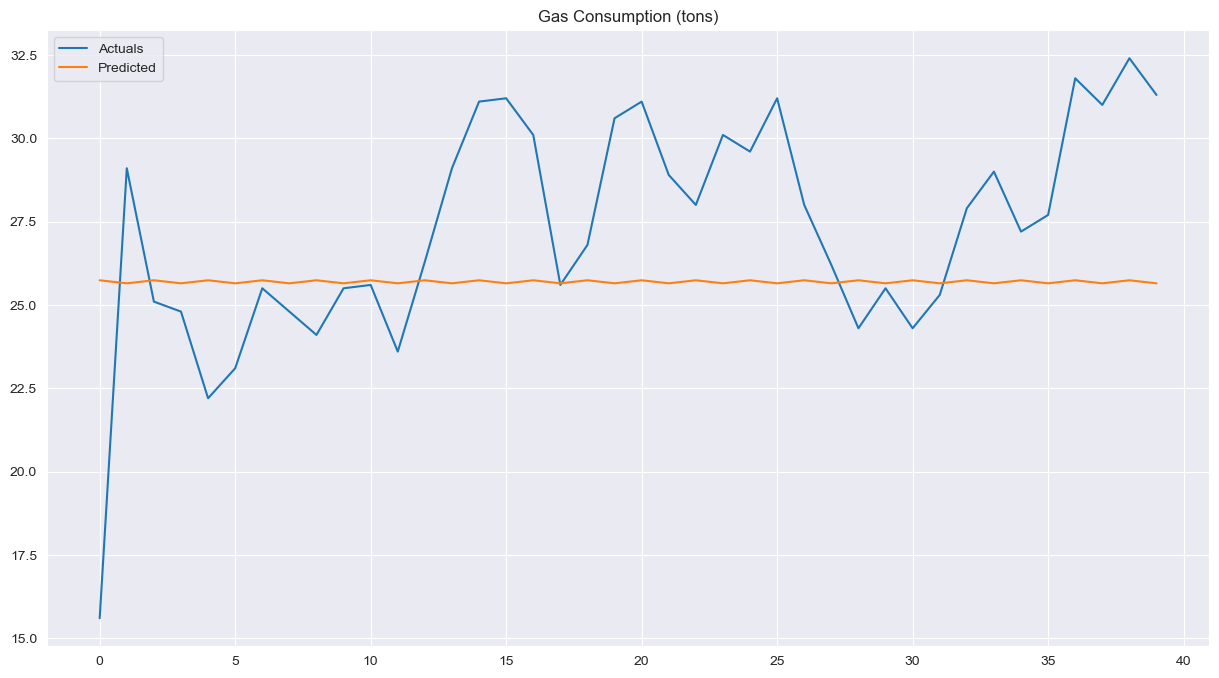

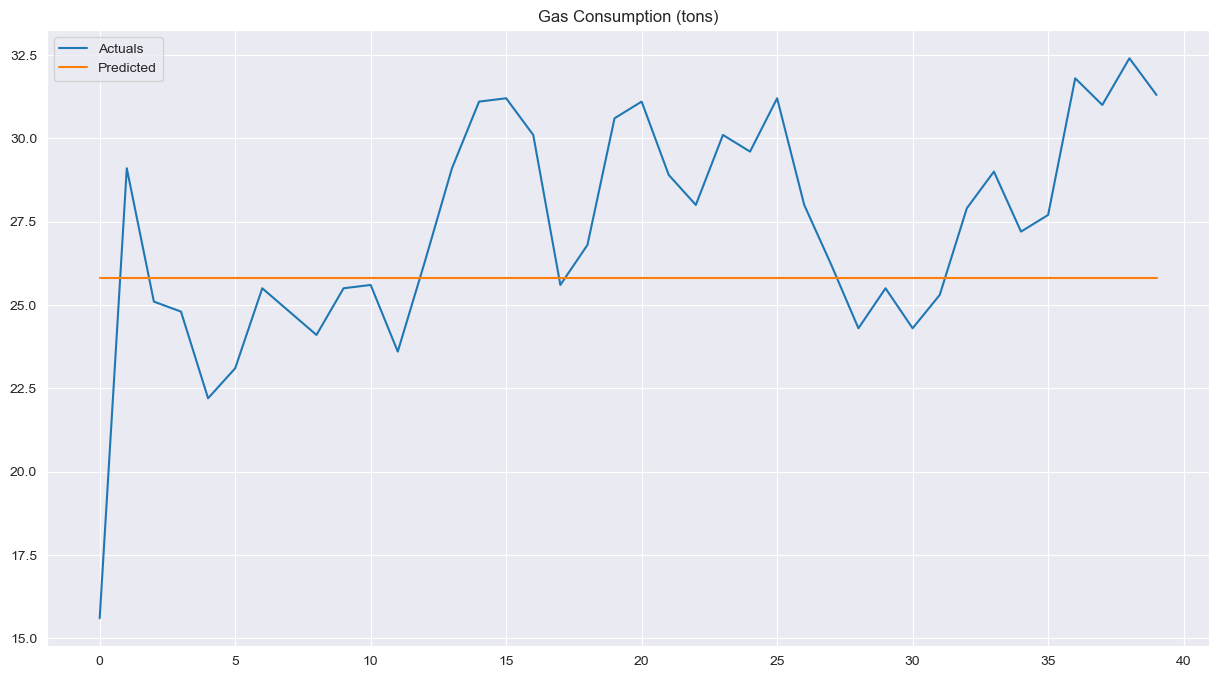

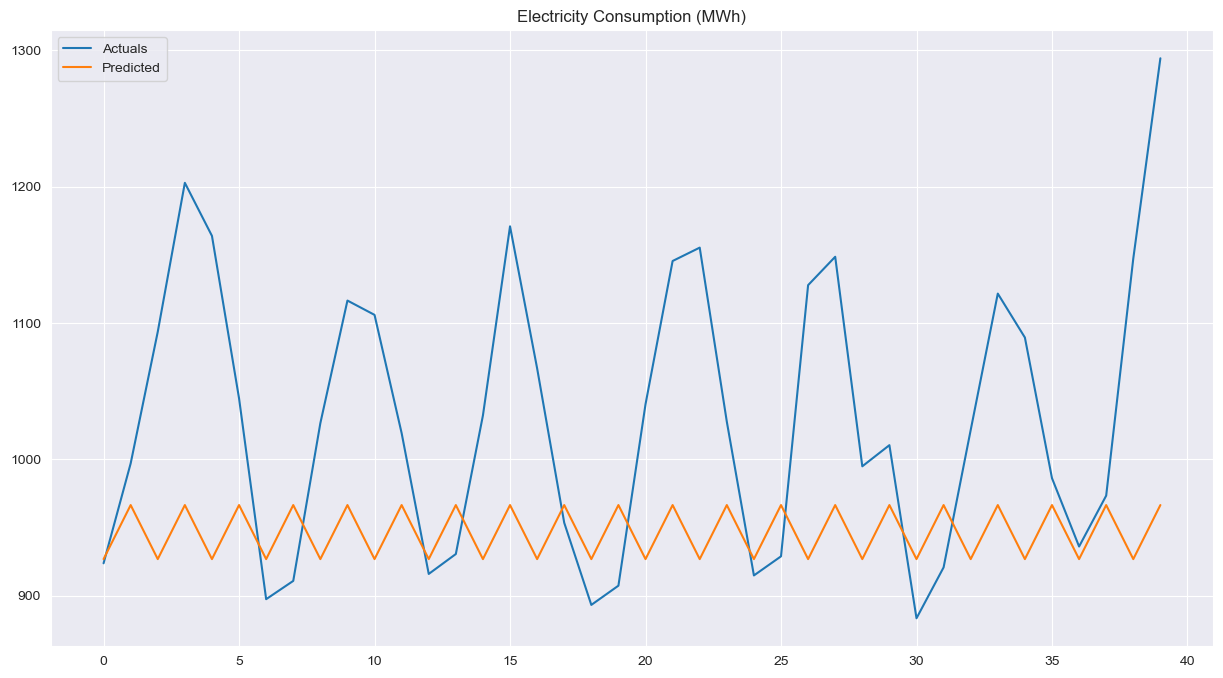

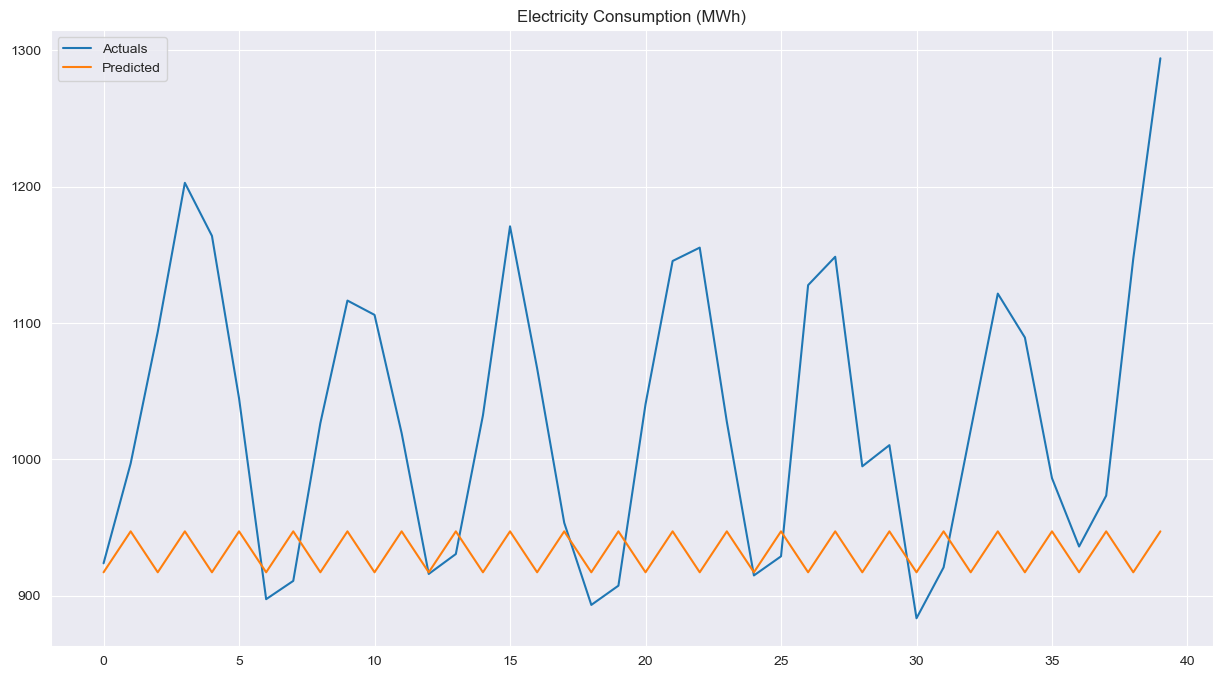

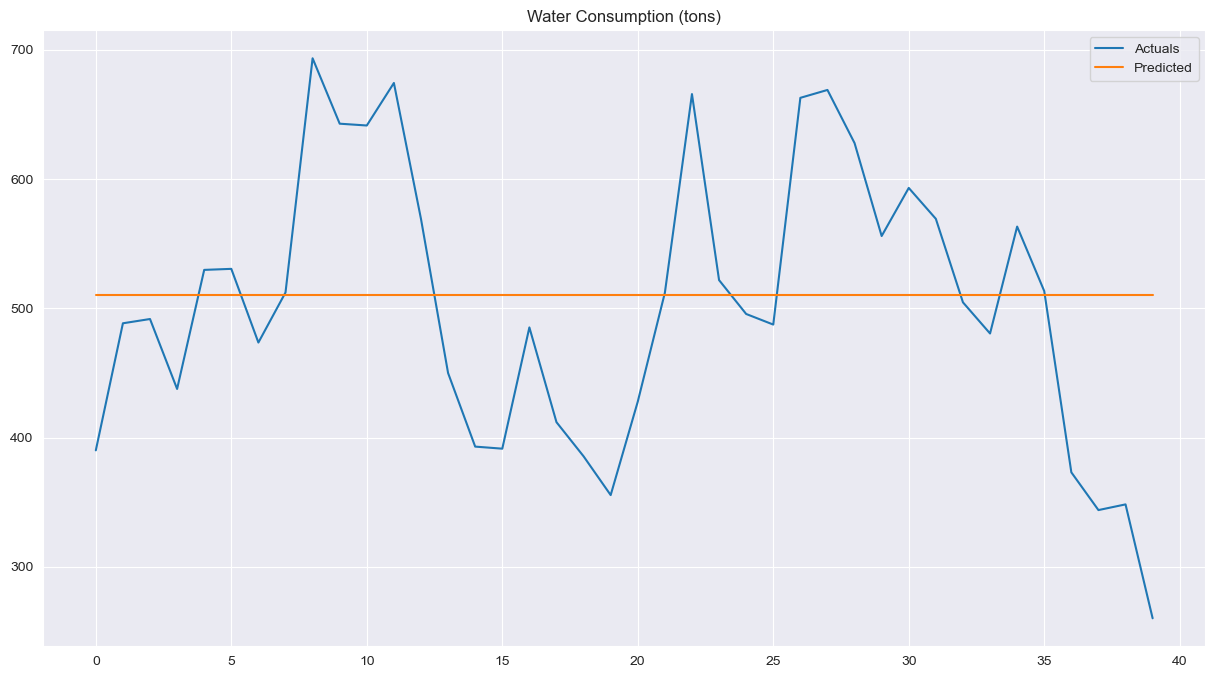

In [29]:
temp = pd.DataFrame()  
step_size = 2
#initiate a dict with the models to be tested

model_dict = {'Gas Consumption (tons)': [[(0,1,1), (0,0,1,12)],
                      [(0,1,1), (0,0,0,12)]],

            'Electricity Consumption (MWh)': [[(0,1,3), (2,1,0,12)],
                            [(2,1,0), (0,1,1,12)]], 

            'Water Consumption (tons)': [[(0,1,1), (0,0,0,12)]]}

#loop through the models and fit them to the data

pred_test_list = pd.DataFrame(columns=train.columns, data = np.zeros((len(test), len(train.columns))))
actuals_test_list = pd.DataFrame(columns=train.columns, data = np.zeros((len(test), len(train.columns))))

for col in model_dict.keys():
    for j in model_dict[col]:
        for i in range(0, len(test), step_size):  # walk forward loop with step size
            train_data = pd.concat([train, test[:i]])
            model = SARIMAX(train[col], order=j[0], seasonal_order=j[1])
            model_fit = model.fit()
            pred_test_list.loc[i:i + step_size - 1, col] = list(model_fit.forecast(steps = step_size))
            actuals_test_list.loc[i:i + step_size - 1, col] = list(test[col][i:i + step_size])  # Use the corresponding range of actuals

            pred_test = np.array(pred_test_list[col][:i + step_size])  # Consider predictions up to the current step
            actuals_test = np.array(actuals_test_list[col][:i + step_size])  # Consider actual up to the current step

            RMSE = mean_squared_error(actuals_test, pred_test, squared=False)
            MAPE = mean_absolute_percentage_error(actuals_test, pred_test)
            aic = model_fit.aic
            bic = model_fit.bic

            result = pd.DataFrame({'Column': col, 'Model': 'Auto ARIMA', 'AIC': aic, 'BIC': bic, 'RMSE': RMSE, 'MAPE': MAPE}, index=[0])
        temp = result.mean().reset_index()
        temp = temp.append(result, ignore_index=True)
        temp['Model'] = 'ARIMA'
        results = results.append(temp[['Column', 'Model', 'AIC', 'BIC', 'RMSE', 'MAPE']].dropna(), ignore_index=True)
        plt.plot(actuals_test, label='Actuals')
        plt.plot(pred_test, label='Predicted')
        plt.title(col)
        plt.legend()
        plt.show()


## Evaluation of Models

As there are many models to compare, i think that it would be better to find the best performing model for each column and use it as a baseline to compare the future hyperparameter tuned model

### Scoring

For this analysis, I used 4 main scores to evaluate the models:

1. **AIC (Akaike Information Criterion):**
   - ``AIC = 2k - 2ln(L)``
   - **k**: The number of parameters in the model (model complexity).
   - **L**: The maximum likelihood estimate of the likelihood function of the model given the data.
   - The AIC penalizes models with a larger number of parameters. The first term, 2k, represents the penalty for the number of parameters, and the second term, 2ln(L), represents the goodness-of-fit of the model (log-likelihood of the data). When comparing different models, a lower AIC value indicates a better model. So, the model with the lowest AIC is considered the best compromise between goodness of fit and complexity.

2. **BIC (Bayesian Information Criterion):**
   - ``BIC = k * ln(n) - 2ln(L)``
   - **k**: The number of parameters in the model (model complexity).
   - **n**: The number of data points in the sample.
   - **L**: The maximum likelihood estimate of the likelihood function of the model given the data.
   - Like AIC, BIC also penalizes models for their complexity, but the penalty is stronger as it includes a term dependent on the number of data points. BIC tends to select simpler models compared to AIC, making it suitable for more robust model selection.

3. **RMSE (Root Mean Squared Error):**
   - ``RMSE = sqrt(Σ (y_true - y_pred)^2 / n)``
   - **y_true**: The actual (observed) values of the dependent variable.
   - **y_pred**: The predicted values of the dependent variable by the model.
   - **Σ**: The summation symbol.
   - **n**: The total number of data points.
   - RMSE is a measure of the difference between predicted values and actual values. It is calculated as the square root of the mean of the squared differences between predicted and actual values. Lower RMSE values indicate better model performance.

4. **MAPE (Mean Absolute Percentage Error):**
   - ``MAPE = (Σ |(y_true - y_pred) / y_true|) * (100 / n)``
   - **y_true**: The actual (observed) values of the dependent variable.
   - **y_pred**: The predicted values of the dependent variable by the model.
   - **Σ**: The summation symbol.
   - **| |**: The absolute value notation.
   - **n**: The total number of data points.
   - MAPE measures the accuracy of predictions as a percentage. It calculates the absolute percentage difference between predicted and actual values, then takes the average. MAPE is useful for interpreting the error in a percentage form, making it easier to understand the model's performance relative to the magnitude of the data.

These scores are essential for evaluating the performance of different models and selecting the most suitable model for the given time series analysis.


### Gas Column
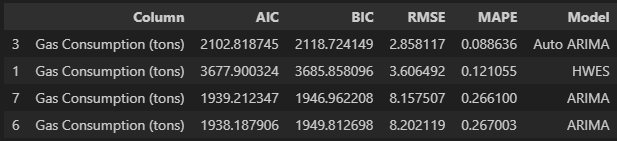

**Holt-Winters Exponential Smoothing (HWES):**


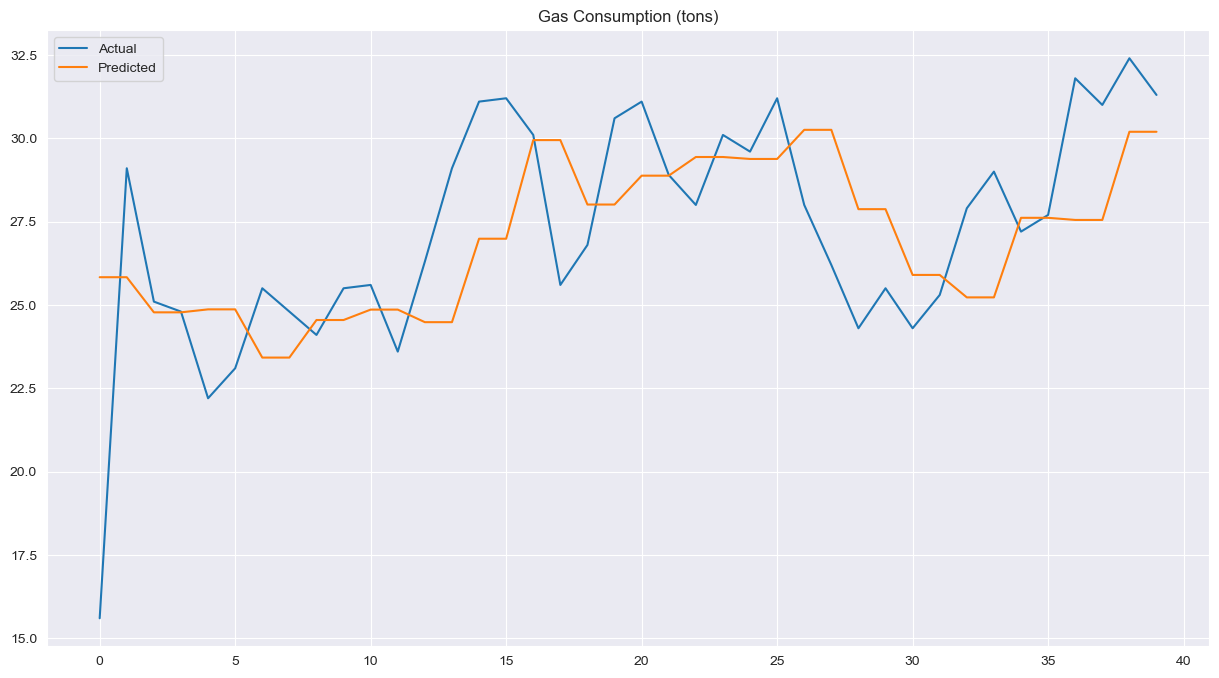


While HWES demonstrates a decent RMSE and MAPE, its higher AIC and BIC scores suggest excessive complexity compared to other models.

**Auto ARIMA Model:** 


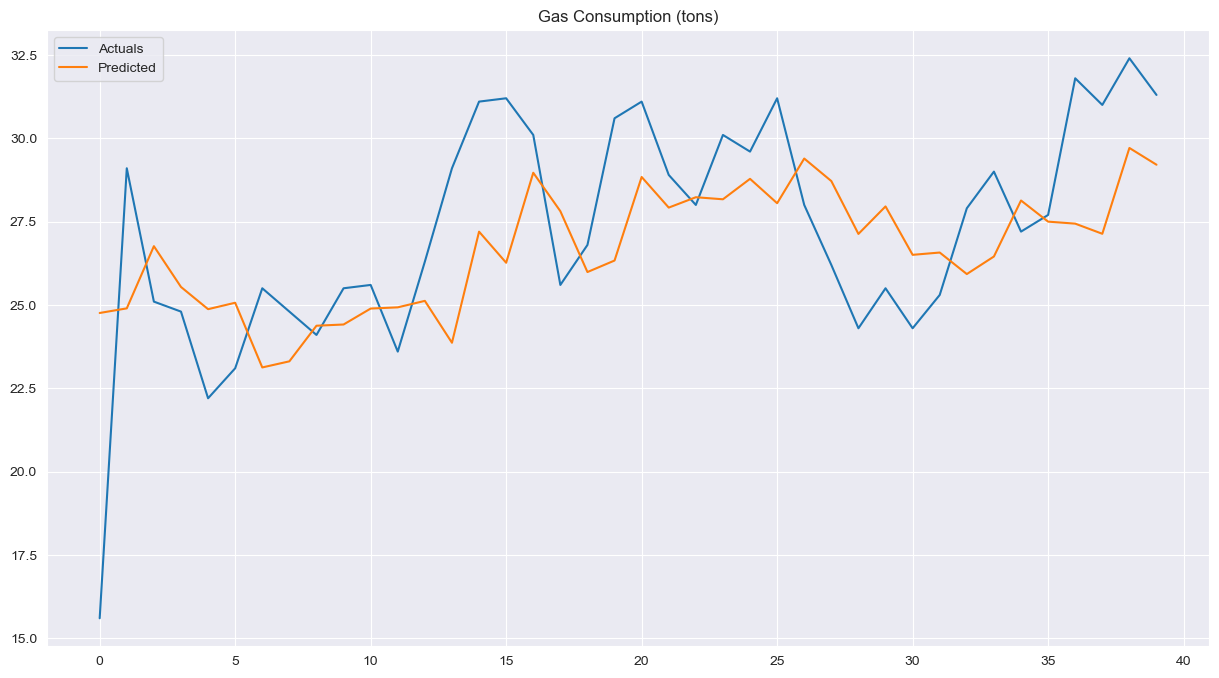


The Auto ARIMA model displays better forecast accuracy with lower RMSE and MAPE values, despite slightly higher AIC and BIC scores compared to HWES.

**ARIMA Models:** 


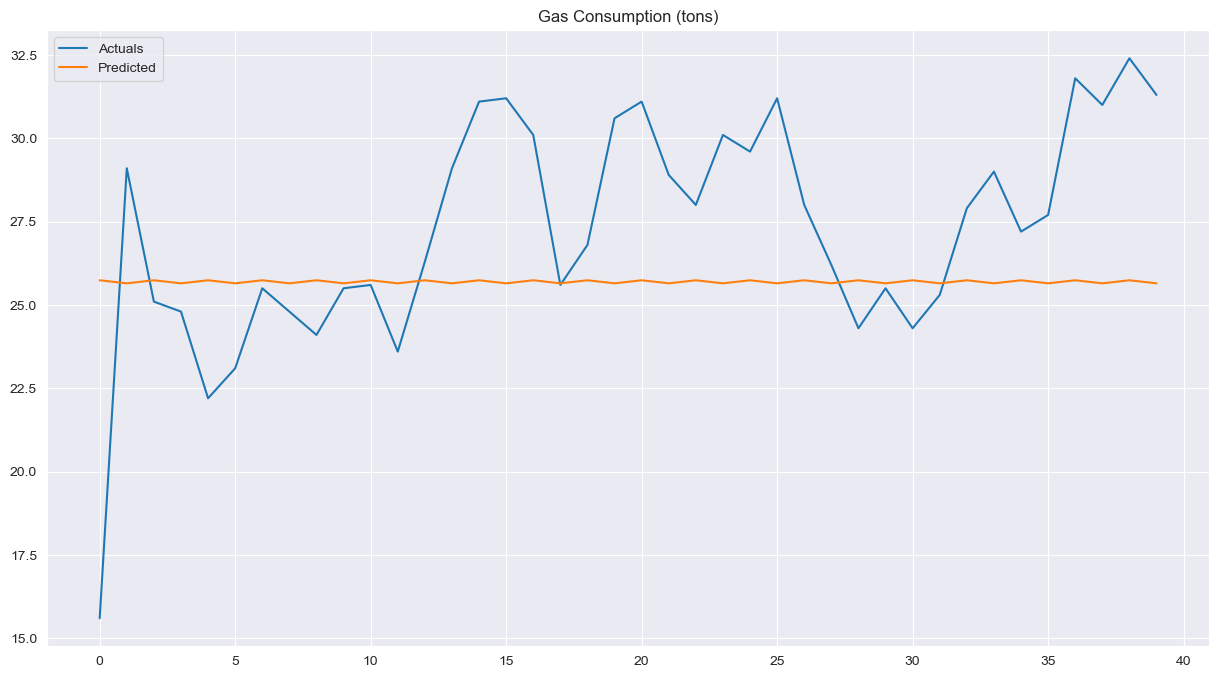
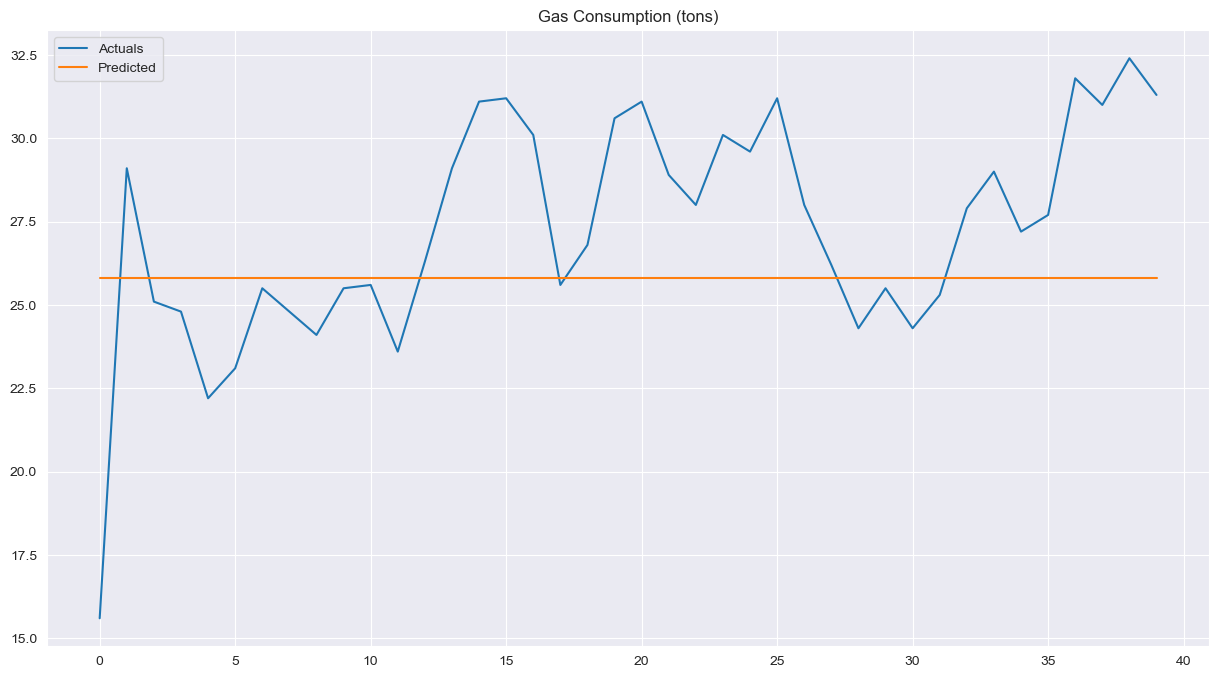

Both ARIMA models exhibit better AIC and BIC scores than HWES, and while they offer better complexity, their RMSE and MAPE values indicate less accurate forecasts than the Auto ARIMA model.

### Electricity Column
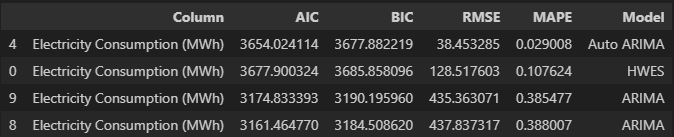

**Holt-Winters Exponential Smoothing (HWES):** 


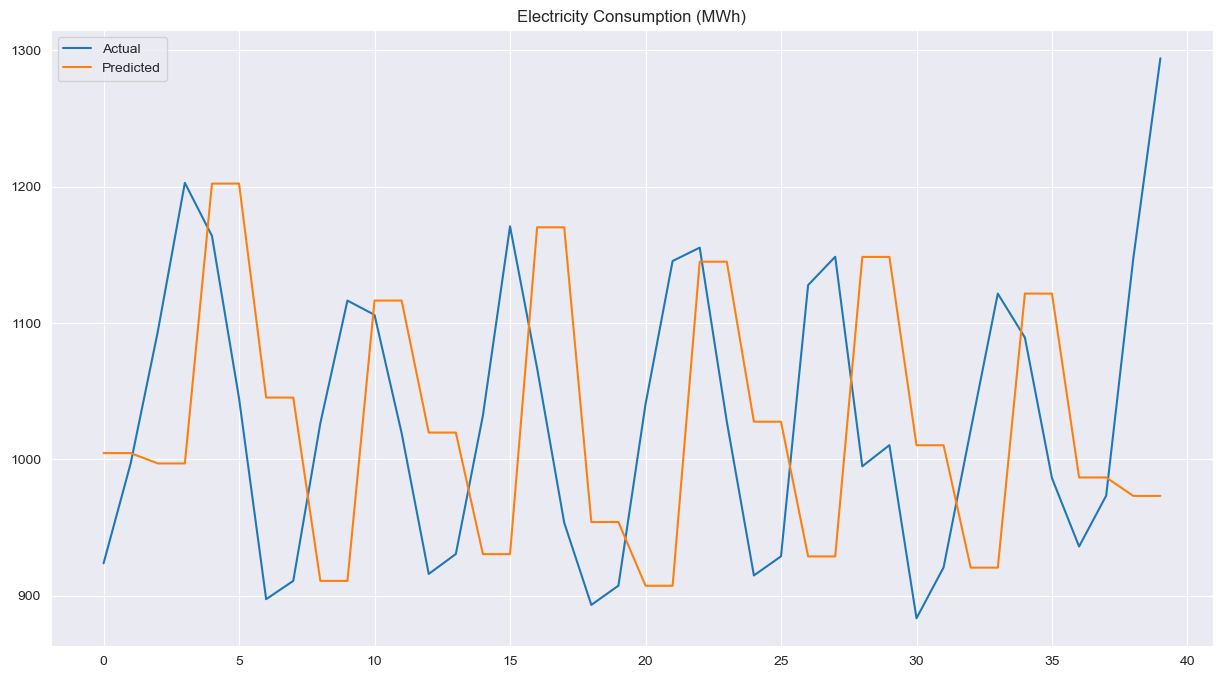


While HWES performs reasonably well in terms of RMSE and MAPE, its higher AIC and BIC scores suggest relative complexity compared to other models.

**Auto ARIMA Model:**


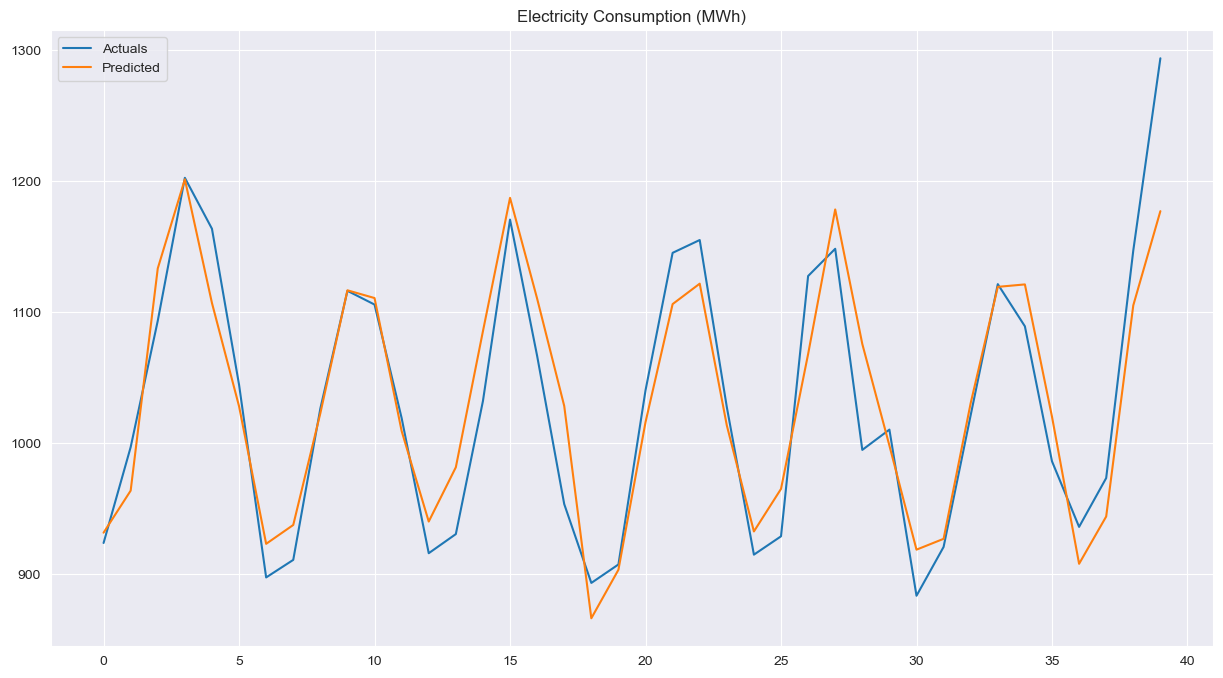


This model showcases the lowest AIC and BIC scores, along with the smallest RMSE and MAPE values, indicating the best overall forecast accuracy.

**ARIMA Models:** 


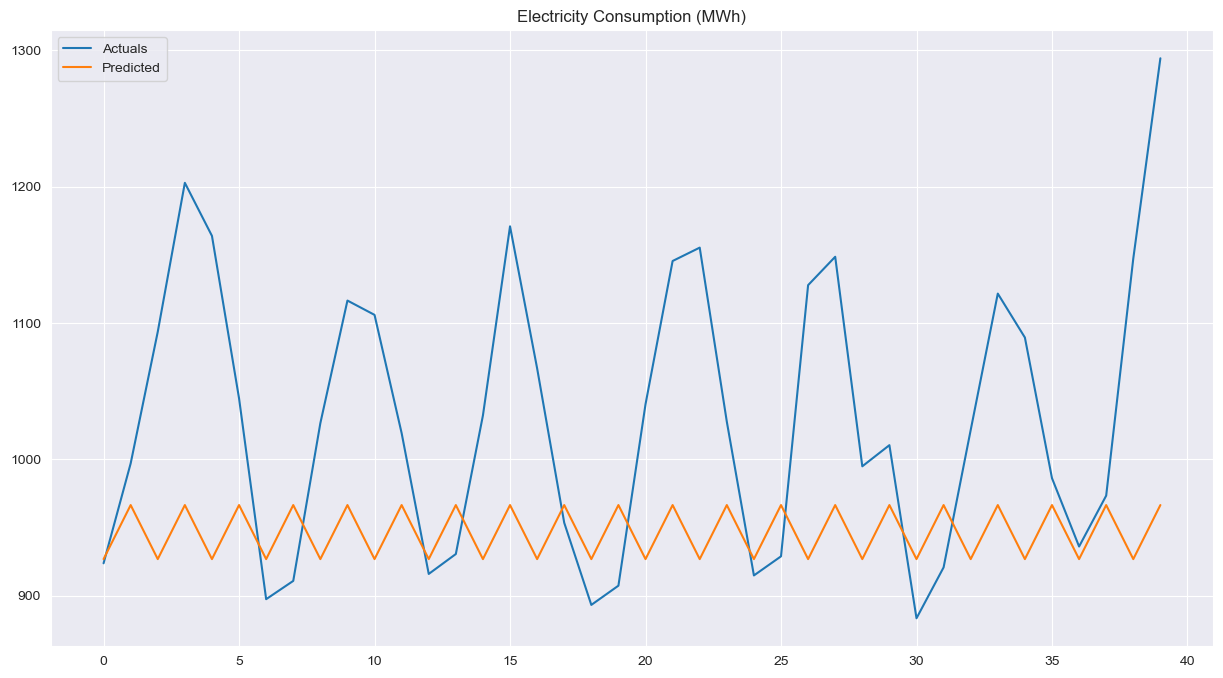
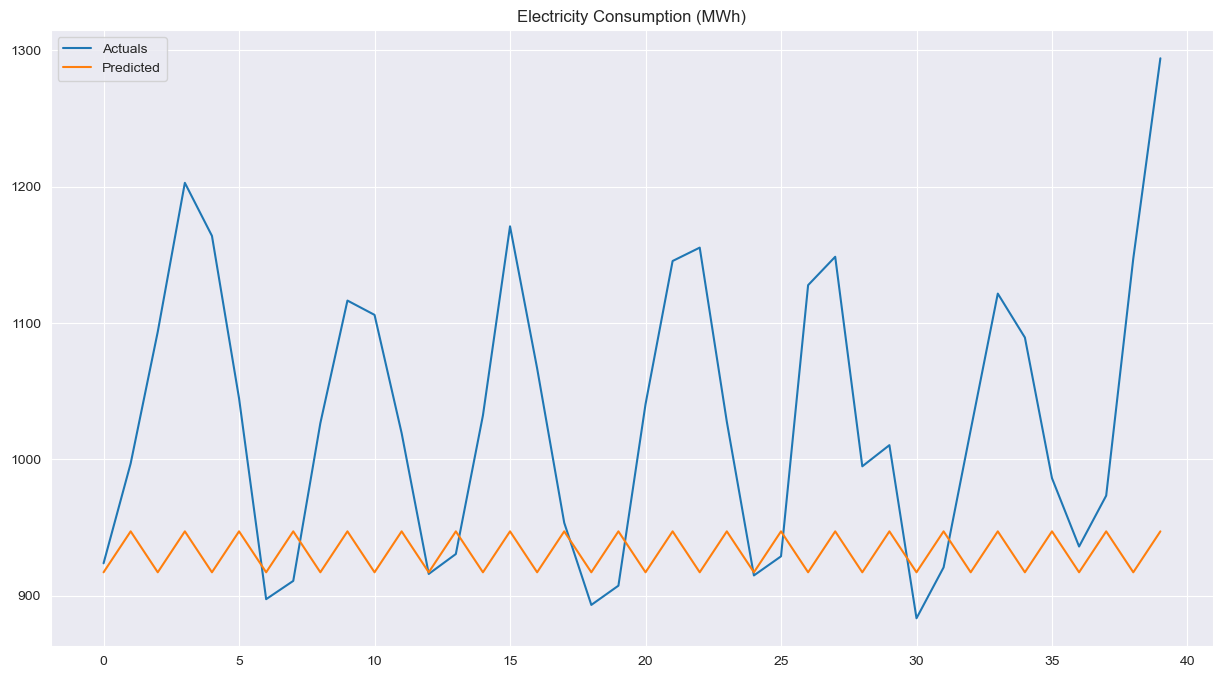


Both ARIMA models exhibit significantly lower AIC and BIC scores compared to HWES, showcasing their better fit. However, their RMSE and MAPE values are relatively high, indicating less accurate forecasts compared to the Auto ARIMA model.



### Water Consumption Column
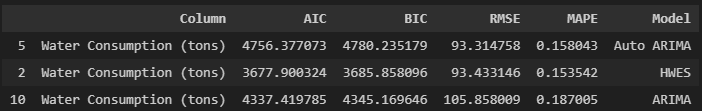



**Holt-Winters Exponential Smoothing (HWES):** 


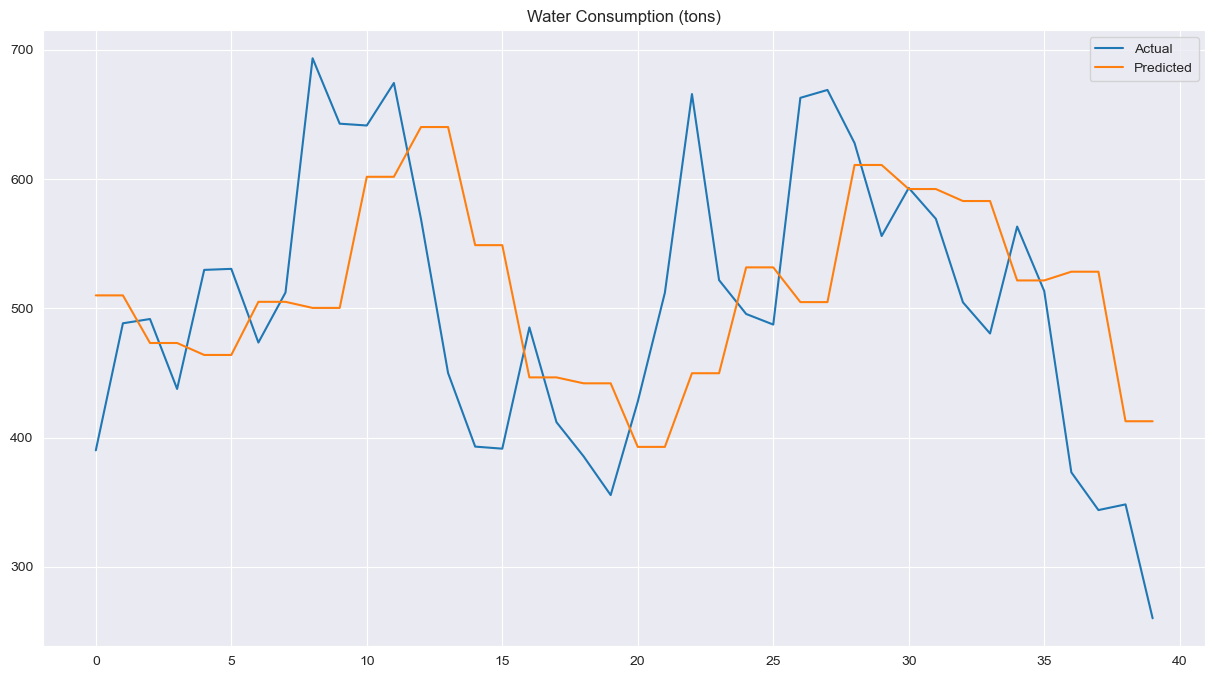


HWES exhibits comparable AIC and BIC scores to the Auto ARIMA model. While it presents a similar RMSE, its slightly lower MAPE suggests overall similar forecast accuracy.



**Auto ARIMA Model:**


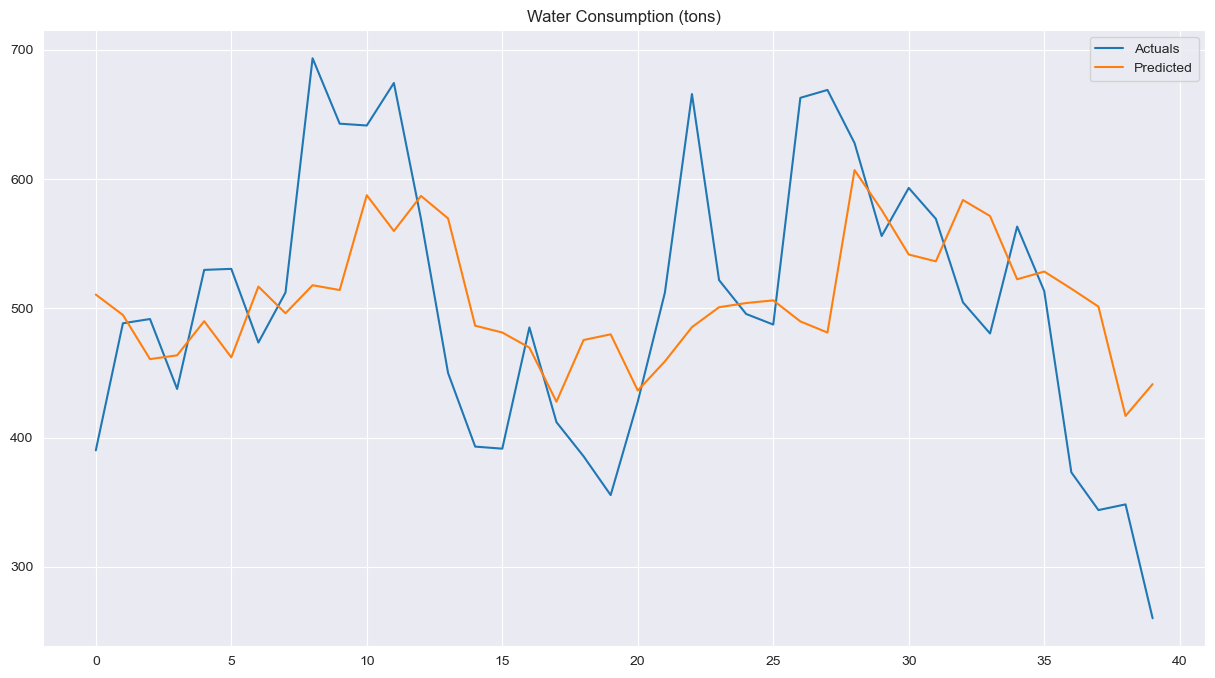


This model demonstrates a relatively higher AIC and BIC, along with a moderate RMSE and MAPE. Despite its accuracy, its complexity might be a trade-off in certain contexts.


**ARIMA Model:**


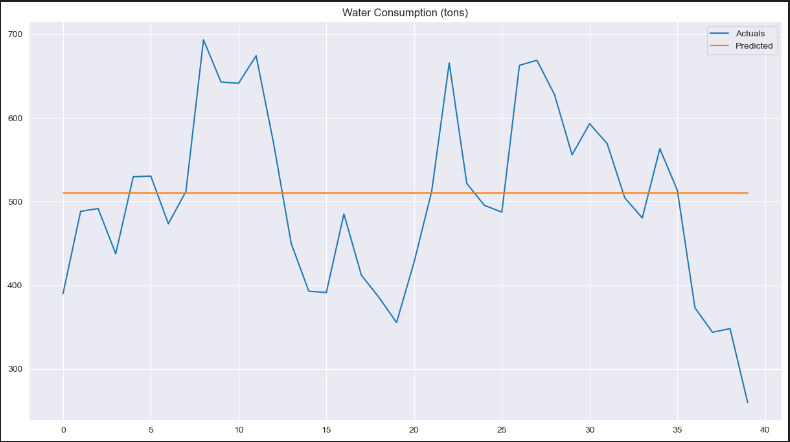


The ARIMA model achieves intermediate AIC and BIC scores. Its RMSE and MAPE values are relatively higher than those of HWES and Auto ARIMA, indicating somewhat less accurate forecasts.


## Hyperparameter Tuning 

From the previous evaluation, we can see that the Auto ARIMA model has decent performance, this can be said to be because Auto ARIMA is hyperparameter tuning in a sense, however this is not the limit of tuning for ARIMA models, we can further improve model performance by tuning the trend as well

### Explaination of Hyperparameter Tuning.

As Auto ARIMA does not tune all the parameters in an ARIMA model, we can write something similar to a grid search to tune it for us. However there is a certain tunable area for these models as there are some rules we must follow.

1. The total sum of differencing cannot be more than 2 (non-seasonal + seasonal)
    - It's important to avoid excessive differencing, as it can lead to overfitting and loss of valuable information.
2. Seasonal Differencing can only be 0 or 1
3. If there is any order of differencing, there cannot be a trend
    - This is because having a trend is kind of contradicatory to differencing, as differencing is supposed to make the data stationary and trendless.
4. Certain trends to not work with the ARIMA function, therefore we will be using the SARIMAX function instead


`!important! I have commented out the actual tuning part so if you run the whole code it wont actually tune the models but instead fetch data of the models from a previously tuned batch`

In [30]:
def generate_poly_lists(length):
    lists = []

    for i in range(2**length):
        binary_str = format(i, f'0{length}b')
        binary_list = [int(bit) for bit in binary_str]


        if binary_list[0] == 1:
            lists.append(binary_list)

    return [np.poly1d(poly_list) for poly_list in lists]




length_of_orders = [3, 4, 5]
all_polynomials = []

#loop thru each order and concat results into 1 list
for order in length_of_orders:
    poly_lists = generate_poly_lists(order)
    all_polynomials.extend(poly_lists)

print(all_polynomials)



[poly1d([1, 0, 0]), poly1d([1, 0, 1]), poly1d([1, 1, 0]), poly1d([1, 1, 1]), poly1d([1, 0, 0, 0]), poly1d([1, 0, 0, 1]), poly1d([1, 0, 1, 0]), poly1d([1, 0, 1, 1]), poly1d([1, 1, 0, 0]), poly1d([1, 1, 0, 1]), poly1d([1, 1, 1, 0]), poly1d([1, 1, 1, 1]), poly1d([1, 0, 0, 0, 0]), poly1d([1, 0, 0, 0, 1]), poly1d([1, 0, 0, 1, 0]), poly1d([1, 0, 0, 1, 1]), poly1d([1, 0, 1, 0, 0]), poly1d([1, 0, 1, 0, 1]), poly1d([1, 0, 1, 1, 0]), poly1d([1, 0, 1, 1, 1]), poly1d([1, 1, 0, 0, 0]), poly1d([1, 1, 0, 0, 1]), poly1d([1, 1, 0, 1, 0]), poly1d([1, 1, 0, 1, 1]), poly1d([1, 1, 1, 0, 0]), poly1d([1, 1, 1, 0, 1]), poly1d([1, 1, 1, 1, 0]), poly1d([1, 1, 1, 1, 1])]


In [31]:
# def ARIMA_tuning(train, test, periods, step_size = 2):
#     temp = pd.DataFrame()
#     df_store = pd.DataFrame()
#     pred_test_list = pd.Series(data = np.zeros((len(test))))
#     actuals_test_list = pd.DataFrame(data = np.zeros((len(test))))

#     for p in tqdm(range(0, 3)):
#         for q in tqdm(range(0, 3)):
#             for P in range(0, 3):
#                 for d, D in [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0)]:
#                     if d + D == 0:
#                         trend_list = ['n', 'c', 't', 'ct'] + all_polynomials
#                     else:
#                         trend_list = ['n']  # No trend terms when d + D > 1
#                     for Q in tqdm(range(0, 3)):
#                             for t in tqdm(trend_list):
#                                 try:
#                                     for i in range(0 , len(test), step_size):
#                                         order = (p, d, q)
#                                         seasonal_order = (P, D, Q, periods)
#                                         model_fit = SARIMAX(train, order=order, seasonal_order=seasonal_order, trend=t).fit()
#                                         forecast = model_fit.predict(start = train.index[i], end = train.index[i + step_size - 1])
#                                         pred_test_list.loc[i:i + step_size-1] = np.array(forecast)
#                                         actuals_test_list.loc[i:i + step_size-1] = np.array(test[i:i + step_size]).reshape(step_size,1)  # Use the corresponding range of actuals
#                                         pred_test = np.array(pred_test_list[:i + step_size])  # Consider predictions up to the current step
#                                         actuals_test = np.array(actuals_test_list[:i + step_size])  # Consider actuals up to the current step

#                                         RMSE = mean_squared_error(actuals_test, pred_test, squared=False)
#                                         MAPE = mean_absolute_percentage_error(actuals_test, pred_test)
#                                         aic = model_fit.aic
#                                         bic = model_fit.bic

#                                         result = pd.DataFrame({'AIC': aic, 'BIC': bic, 'RMSE': RMSE, 'MAPE': MAPE}, index=[0])
#                                     temp = result.mean().reset_index()
#                                     temp = temp.append(result, ignore_index=True)  # Append the result to the DataFrame
#                                     temp['Model'] = (order, seasonal_order, t)
#                                     df_store = df_store.append(temp, ignore_index=True)
#                                 except: 
#                                     print(f'Error with model{(order, seasonal_order, t)}')

#     return df_store


In [32]:
# #tune the ARIMA model for the gas column
# df_store = ARIMA_tuning(train['Gas Consumption (tons)'], test['Gas Consumption (tons)'],12)
# df_store.to_csv('Saved Tuned Models\electricity_tuning.csv')


# df_store = ARIMA_tuning(train['Electricity Consumption (MWh)'], test['Gas Consumption (tons)'],12)
# df_store.to_csv('Saved Tuned Models\electricity_tuning.csv')


# df_store = ARIMA_tuning(train['Water Consumption (tons)'], test['Gas Consumption (tons)'],12)
# df_store.to_csv('Saved Tuned Models\water_tuning.csv')

In [33]:
#Gas
gas = pd.read_csv('Saved Tuned Models\gas_tuning.csv')
top = gas.sort_values(by=['RMSE'], ascending=True).iloc[0]
top.drop(['Unnamed: 0'], inplace=True)
top['Column'] = 'Gas Consumption (tons)'
results = results.append(top)

#Electricity
elec = pd.read_csv('Saved Tuned Models\electricity_tuning.csv')
top = elec.sort_values(by=['RMSE'], ascending=True).iloc[0]
top.drop(['Unnamed: 0'], inplace=True)
top['Column'] = 'Electricity Consumption (MWh)'
results = results.append(top)

#Water
water = pd.read_csv('Saved Tuned Models\water_tuning.csv')
top = water.sort_values(by=['RMSE'], ascending=True).iloc[0]
top.drop(['Unnamed: 0'], inplace=True)
top['Column'] = 'Water Consumption (tons)'
results = results.append(top)

In [34]:
#compare gas

results[results['Column'] == 'Gas Consumption (tons)'].sort_values(by=['RMSE'], ascending=True)

Column          AIC          BIC      RMSE      MAPE  \
3     Gas Consumption (tons)  2102.818745  2118.724149  2.858117  0.088636   
1374  Gas Consumption (tons)  1853.462519  1872.257027  3.277288  0.118023   
1     Gas Consumption (tons)  3677.900324  3685.858096  3.606492  0.121055   
7     Gas Consumption (tons)  1939.212347  1946.962208  3.624593  0.106458   
6     Gas Consumption (tons)  1938.187906  1949.812698  3.682927  0.106947   

                                Model  
3                          Auto ARIMA  
1374  ((1, 0, 1), (1, 0, 0, 12), 't')  
1                                HWES  
7                               ARIMA  
6                               ARIMA

### Final Gas Tuned Evaluation


On analyzing the provided data, we notice 2 notable models for forecasting gas. Specifically, the Auto ARIMA model and a tuned ARIMA model stand out with their excellant performance. Let's outline the strengths of each model to facilitate an informed selection.

1. Auto ARIMA Model:

- AIC: 2102.818745
- BIC: 2118.724149
- RMSE: 2.858117
- MAPE: 0.088636
- This model demonstrates competitive accuracy with a relatively low RMSE and MAPE, it can be said to provide the most accurate forecasts.

2. Tuned ARIMA Model:

- AIC: 1853.462519
- BIC: 1872.257027
- RMSE: 3.277288
- MAPE: 0.118023
- Utilizing a specific parameter configuration ((1, 0, 1), (1, 0, 0, 12), 't'), this model showcases commendable accuracy with a decent RMSE and MAPE, however the selling of this model is that it has a low AIC and BIC compared to the other models.


As i would prefer a model with balanced complexity as well as accuracy, i will be selecting the **tuned ARIMA** model as the final model for the gas column

In [35]:
#compare electricity 

results[results['Column'] == 'Electricity Consumption (MWh)'].sort_values(by=['RMSE'], ascending=True)

Column          AIC          BIC        RMSE  \
536  Electricity Consumption (MWh)  2801.634800  2820.219938   33.019290   
4    Electricity Consumption (MWh)  3654.024114  3677.882219   38.453285   
0    Electricity Consumption (MWh)  3677.900324  3685.858096  128.517603   
8    Electricity Consumption (MWh)  3161.464770  3184.508620  132.146900   
9    Electricity Consumption (MWh)  3174.833393  3190.195960  141.548238   

         MAPE                            Model  
536  0.023145  ((0, 1, 1), (1, 1, 2, 12), 'n')  
4    0.029008                       Auto ARIMA  
0    0.107624                             HWES  
8    0.093985                            ARIMA  
9    0.099344                            ARIMA

### Final Electricty Evaluation


We can list down the scores for each models and compare them from there.

1. **Tuned ARIMA Model (Configuration: ((0, 1, 1), (1, 1, 2, 12), 'n')):**
   - AIC: 2801.634800
   - BIC: 2820.219938
   - RMSE: 33.019290
   - MAPE: 0.023145
   - This model showcases the best scores across all metrics, with notably low RMSE and MAPE values, indicating its strong forecasting capabilities.

2. **Auto ARIMA Model:**
   - AIC: 3654.024114
   - BIC: 3677.882219
   - RMSE: 38.453285
   - MAPE: 0.029008
   - While having ok performance, this model's RMSE and MAPE values are higher than those of the tuned ARIMA model.

3. **Holt-Winters Exponential Smoothing (HWES):**
   - AIC: 3677.900324
   - BIC: 3685.858096
   - RMSE: 128.517603
   - MAPE: 0.107624
   - HWES exhibits reasonable performance, but its RMSE and MAPE scores are higher compared to the tuned ARIMA model.

4. **ARIMA Models:**
   - Both ARIMA models (with AIC values of 3161.464770 and 3174.833393) showcase decent complexity. However, their RMSE and MAPE values are higher than those of the tuned ARIMA model.

Given these observations, the **tuned ARIMA model** emerges as the optimal choice due to its consistently superior performance across all metrics. This well-tuned configuration is well-suited for accurately forecasting Electricity Consumption (MWh) based on the provided data.


In [36]:
#compare Water

results[results['Column'] == 'Water Consumption (tons)'].sort_values(by=['RMSE','MAPE'], ascending=True)

Column          AIC          BIC        RMSE  \
5     Water Consumption (tons)  4756.377073  4780.235179   93.314758   
2     Water Consumption (tons)  3677.900324  3685.858096   93.433146   
2129  Water Consumption (tons)  3771.288195  3793.590361  101.108278   
10    Water Consumption (tons)  4337.419785  4345.169646  105.858009   

          MAPE                            Model  
5     0.158043                       Auto ARIMA  
2     0.153542                             HWES  
2129  0.182453  ((2, 1, 0), (1, 1, 2, 12), 'n')  
10    0.187005                            ARIMA

### Final Water Tuned Evaluation

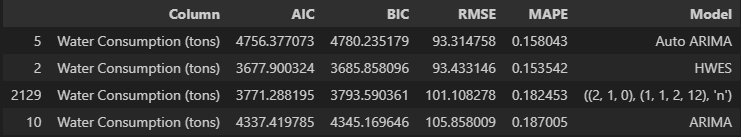

By looking at the table, we can consider these models,

1. **Auto ARIMA Model:**
   - AIC: 4756.377073
   - BIC: 4780.235179
   - RMSE: 93.314758
   - MAPE: 0.158043
   - This model demonstrates high accuracy, as seen from its low RMSE and MAPE scores.

2. **Holt-Winters Exponential Smoothing (HWES):**
   - AIC: 3677.900324
   - BIC: 3685.858096
   - RMSE: 93.433146
   - MAPE: 0.153542
   - HWES exhibits similar accuracy to the Auto ARIMA model, but with significantly lower AIC and BIC scores.

3. **Tuned ARIMA Model (Configuration: ((2, 1, 0), (1, 1, 2, 12), 'n')):**
   - AIC: 3771.288195
   - BIC: 3793.590361
   - RMSE: 101.108278
   - MAPE: 0.182453
   - While offering reasonable accuracy, this tuned ARIMA configuration displays higher RMSE and MAPE values compared to HWES and Auto ARIMA.

Considering these observations, the **HWES model** emerges as a particularly promising choice for the Water Consumption (tons) column. Its balanced accuracy scores, along with significantly lower AIC and BIC scores, position it as a strong candidate for accurate forecasting in this context.



# Final Forecasting

In [37]:
def get_best_params(path):
    best = pd.read_csv(path) 
    best = best.sort_values(by='RMSE', ascending = True).iloc[0]['Model']

    #split the string to get order and seasonal order
    order_str, seasonal_order_str, trend = eval(best)

    # Converting the order and seasonal order strings to integers
    order = tuple(map(int, order_str))
    seasonal_order = tuple(map(int, seasonal_order_str))
    print('params for:', path)
    print('order:', order, 'seasonal_order:', seasonal_order, 'trend:', trend)
    return order, seasonal_order, trend

In [38]:
#gas
gas_order, gas_seasonal, gas_trend = get_best_params('Saved Tuned Models\gas_tuning.csv')

#electricity
elec_order, elec_seasonal, elec_trend = get_best_params('Saved Tuned Models\electricity_tuning.csv')

params for: Saved Tuned Models\gas_tuning.csv
order: (1, 0, 1) seasonal_order: (1, 0, 0, 12) trend: t
params for: Saved Tuned Models\electricity_tuning.csv
order: (0, 1, 1) seasonal_order: (1, 1, 2, 12) trend: n


### Gas

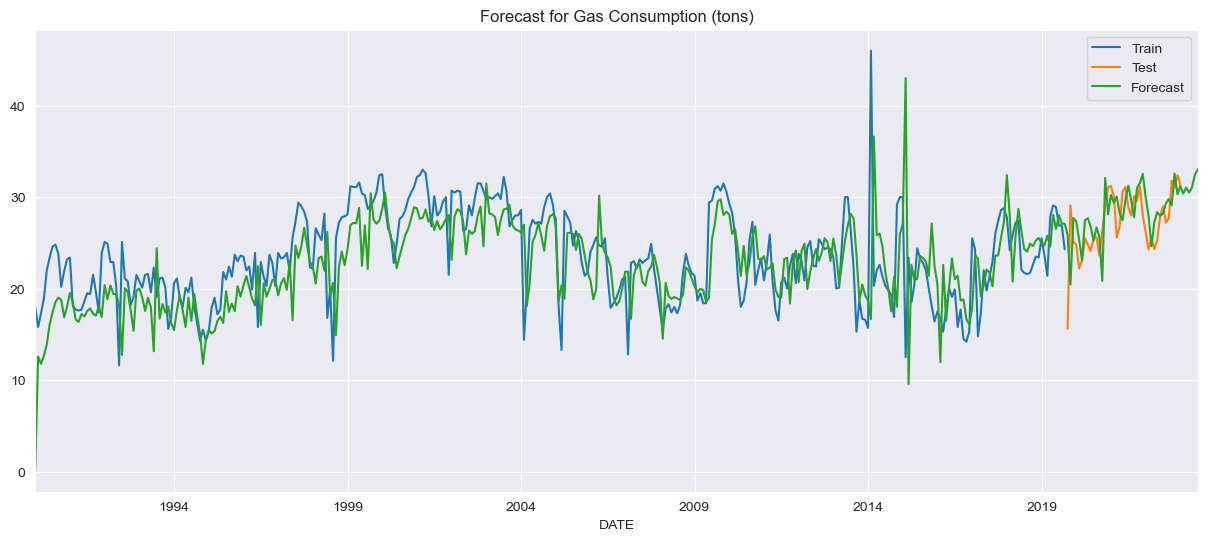

In [39]:
#fit the models and predict the next 6 months

gas_model = SARIMAX(initialdata['Gas Consumption (tons)'], order=gas_order, seasonal_order=gas_seasonal, trend = gas_trend)
gas_model_fit = gas_model.fit()
gas_yhat = gas_model_fit.forecast(steps=6)
forecast = gas_model_fit.predict(start = train.index[0], end = test.index[-1])
forecast = forecast.append(gas_yhat)
forecastcompare(forecast, 'Gas Consumption (tons)')

### Electricity

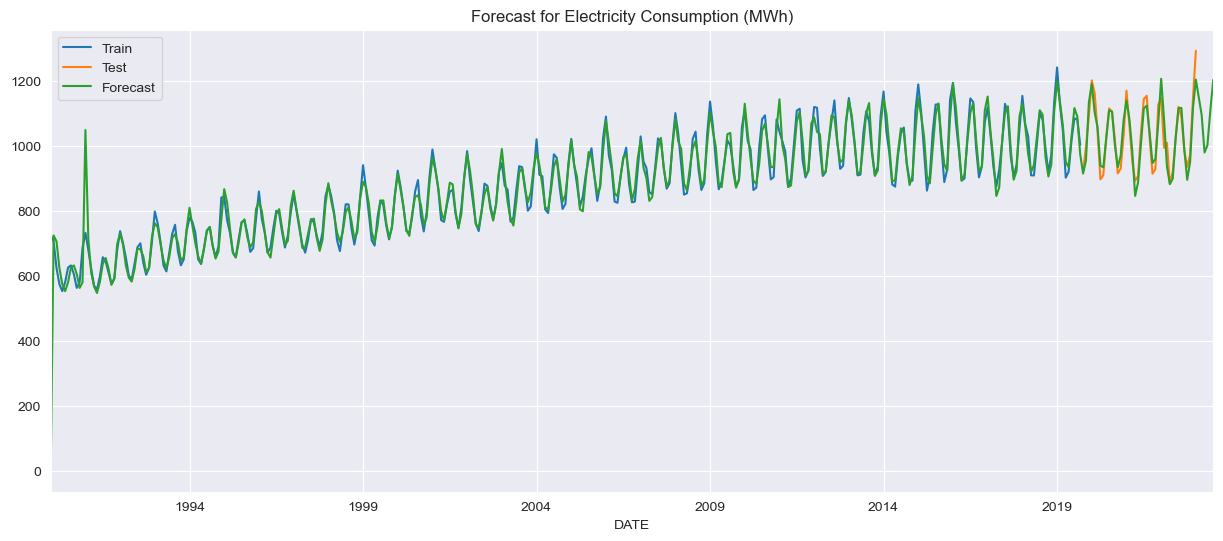

In [40]:
#electricity consumption
elec_model = SARIMAX(initialdata['Electricity Consumption (MWh)'], order=elec_order, seasonal_order=elec_seasonal, trend = elec_trend)
elec_model_fit = elec_model.fit()
elec_yhat = elec_model_fit.forecast(steps=6)
forecast = elec_model_fit.predict(start = train.index[0], end = test.index[-1])
forecast = forecast.append(elec_yhat)
forecastcompare(forecast, 'Electricity Consumption (MWh)')



### Water

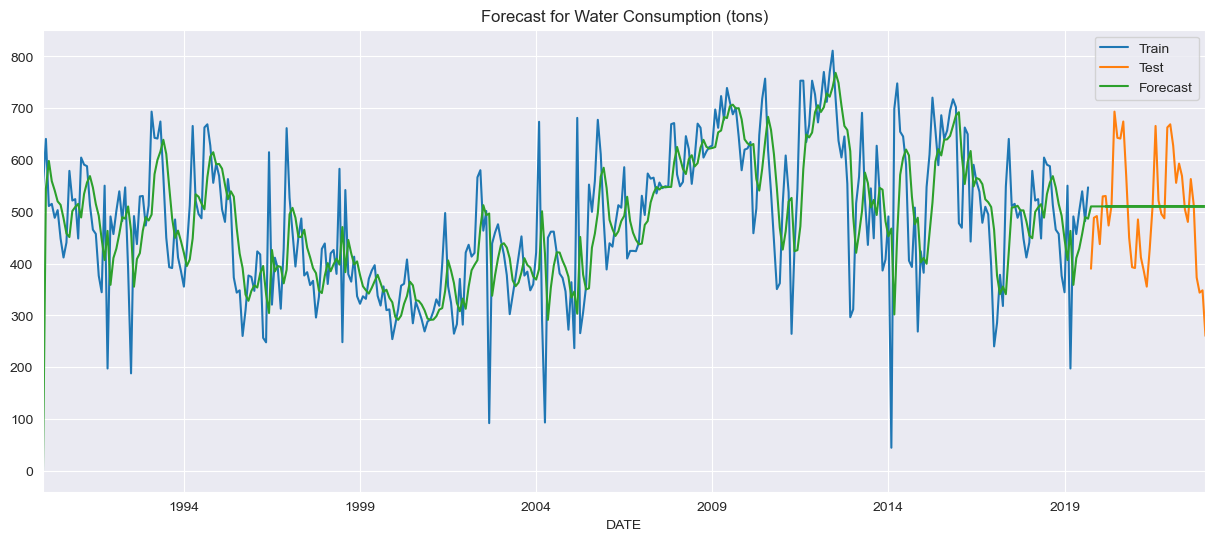

In [41]:
#water consumption

water_model = HWES(train_data[o], seasonal_periods=12)
water_model_fit = model.fit()
water_yhat = water_model_fit.forecast(steps=6)
forecast = water_model_fit.predict(start = train.index[0], end = test.index[-1])
forecast = forecast.append(water_yhat)
forecastcompare(forecast, 'Water Consumption (tons)')

References:

["https://stackoverflow.com/questions/62210221/walk-forward-with-validation-window-for-time-series-data-cross-validation"](https://stackoverflow.com/questions/62210221/walk-forward-with-validation-window-for-time-series-data-cross-validation)



["https://people.duke.edu/~rnau/arimrule.htm"](https://people.duke.edu/~rnau/arimrule.htm)